In [2306]:
import pandas as pd
import numpy as np
import seaborn as sns
from metric import metric, metricC, metricT
import seaborn as sns
import matplotlib.pyplot as plt

In [2307]:
folder = 'data_task1/'

In [2308]:
import os
os.listdir(folder)

['plavki_test.csv',
 'chronom_test.csv',
 'produv_train.csv',
 'chugun_test.csv',
 'sip_test.csv',
 'gas_train.csv',
 'sip_train.csv',
 'lom_test.csv',
 'lom_train.csv',
 'sample_submission.csv',
 'plavki_train.csv',
 'produv_test.csv',
 'gas_test.csv',
 'chronom_train.csv',
 'chugun_train.csv',
 'target_train.csv']

In [2309]:
ss = pd.read_csv(folder + 'sample_submission.csv')

In [2310]:
tables = ['sip', 'chugun', 'produv', 'lom', 'plavki', 'chronom', 'target']

In [2311]:
sip = pd.read_csv(folder + 'sip_train.csv')
chugun = pd.read_csv(folder + 'chugun_train.csv')
produv = pd.read_csv(folder + 'produv_train.csv')
lom = pd.read_csv(folder + 'lom_train.csv')
plavki = pd.read_csv(folder + 'plavki_train.csv')
chronom = pd.read_csv(folder + 'chronom_train.csv')
gas = pd.read_csv(folder + 'gas_train.csv')
target = pd.read_csv(folder + 'target_train.csv')

In [2312]:
target['date'] = pd.to_datetime(produv.groupby('NPLV').last()['SEC']).values

In [2313]:
# Генерим фичи с таблицы chronom
def prepare_chronom_features(chronom):

    chronom['VR_NACH'] = pd.to_datetime(chronom['VR_NACH'])
    chronom['VR_KON'] = pd.to_datetime(chronom['VR_KON'])

    temp = chronom[chronom['NOP'] == 'Продувка']
    chronom_features = pd.DataFrame(index=temp['NPLV'])
    chronom_features['duration'] = (temp['VR_KON'] - temp['VR_NACH']).dt.seconds.values
    chronom_features['O2_sum'] = chronom.groupby('NPLV')['O2'].sum().values
    chronom_features.head()
    return chronom_features

In [2314]:
# Генерим фичи с таблицы sap
def prepare_sip_features(sip):

    sip_features = sip.pivot_table(index='NPLV', columns='NMSYP', values='VSSYP', aggfunc=['mean', 'sum', 'count', 'std'])
    sip_features = sip.groupby(['NPLV'])[['VSSYP']].sum()
    #sip_features.columns = ['_'.join(x) for x in sip_features.columns]
    return sip_features


In [2315]:
def prepare_chugun_features(chugun):
    chugun_features = chugun.drop(columns='DATA_ZAMERA').set_index('NPLV')
    return chugun_features



In [2316]:
# produv

def prepare_produv_features(produv, chronom):
    temp = chronom[chronom['NOP'] == 'Продувка']
    produv['SEC'] = pd.to_datetime(produv['SEC'])
    produv = produv.merge(temp, on='NPLV')
    produv = produv[(produv['SEC'] > produv['VR_NACH']) & (produv['SEC'] < produv['VR_KON'])]

    produv_features = produv.groupby('NPLV')[['RAS', 'POL']].agg(['mean', 'max', 'median', 'sum', 'count'])
    produv_features.columns = ['_'.join(x) for x in produv_features.columns]
    return produv_features

In [2317]:
# lom

def prepare_lom_features(lom):
    lom = lom[lom['NML'] != 'НБ  ']
    lom_features = lom.pivot_table(index='NPLV', columns='NML', values='VES', aggfunc=['sum'])
    lom['VES'] = lom.groupby('NPLV')['VES'].mean()
    
    lom_features.columns = ['_'.join(x) for x in lom_features.columns]
    return lom_features

In [2318]:
# gas

def prepare_gas_features(gas):
    features_cols = gas.columns[2: ]
    gas_features = gas.groupby('NPLV')[features_cols].agg(['mean', 'sum', 'max', 'min'])
    gas_features.columns = ['_'.join(x) for x in gas_features.columns]
    return gas_features

In [2319]:
chronom_features = prepare_chronom_features(chronom)
sip_features = prepare_sip_features(sip)
chugun_features = prepare_chugun_features(chugun)
produv_features = prepare_produv_features(produv, chronom)
lom_features = prepare_lom_features(lom)
gas_features = prepare_gas_features(gas)

/home/dro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [2320]:
X = pd.concat([chronom_features, chugun_features, produv_features, lom_features, gas_features], axis=1)
y = target.set_index('NPLV')

In [2321]:
f_columns = X.columns
X.columns = [f'feature_{i}' for i in range(X.shape[1])]

In [2322]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2323]:
def scoringT(estimator, X, y):
    return metricT(y, estimator.predict(X))

In [2324]:
def scoringC(estimator, X, y):
    return metricC(y, estimator.predict(X))

In [2354]:
m = 3
X_train = X[target['date'].dt.month.values <= m]
y_train = y[target['date'].dt.month.values <= m]
X_test = X[target['date'].dt.month.values > m]
y_test = y[target['date'].dt.month.values > m]

In [2355]:
regT = lgb.LGBMRegressor(num_leaves=7, n_estimators=100)
regT.fit(X_train, np.log(y_train['TST'].clip(1550, 1700)))

LGBMRegressor(num_leaves=7)

In [2356]:
metricT(y_train['TST'], regT.predict(X_train))

0.0

In [2357]:
metricT(y_test['TST'], np.exp(regT.predict(X_test)))

0.6425438596491229

In [2409]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor

In [2401]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train.loc[:, X.isna().sum() == 0].clip(0, 10000))
X_test_ = scaler.transform(X_test.loc[:, X.isna().sum() == 0].clip(0, 10000))

In [2402]:
regC = lgb.LGBMRegressor(num_leaves=7)
#regC = Lasso()
regC.fit(X_train, np.log(1 + np.log(1 + np.log(1 + y_train['C'].clip(0.02, 0.08)))))
metricC(y_train['C'], regC.predict(X_train))

0.7467330429371499

In [2403]:
metricC(y_test['C'], regC.predict(X_test))

0.7324561403508771

In [2404]:
regC = LinearRegression()
regC.fit(X_train_,  np.log(1 + y_train['C'].fillna(0.02).clip(0.02, 0.08)))

LinearRegression()

In [2410]:
regC = Ridge(50)
regC.fit(X_train_,  np.log(1 + y_train['C'].fillna(0.04).clip(0.02, 0.08)))

Ridge(alpha=50)

In [2411]:
metricC(y_test['C'], regC.predict(X_test_))

0.7390350877192983

In [2168]:
sip = pd.read_csv(folder + 'sip_test.csv')
chugun = pd.read_csv(folder + 'chugun_test.csv')
produv = pd.read_csv(folder + 'produv_test.csv')
lom = pd.read_csv(folder + 'lom_test.csv')
plavki = pd.read_csv(folder + 'plavki_test.csv')
chronom = pd.read_csv(folder + 'chronom_test.csv')
gas = pd.read_csv(folder + 'gas_test.csv')

In [2169]:
ss = pd.read_csv(folder + 'sample_submission.csv')

In [2170]:
chronom_features = prepare_chronom_features(chronom)
sip_features = prepare_sip_features(sip)
chugun_features = prepare_chugun_features(chugun)
produv_features = prepare_produv_features(produv, chronom)
lom_features = prepare_lom_features(lom)
gas_features = prepare_gas_features(gas)

In [2171]:
X_test = pd.concat([chronom_features, chugun_features, produv_features, lom_features, gas_features], axis=1)
X_test.columns = [f'feature_{i}' for i in range(X_test.shape[1])]

In [2172]:
X_test = X_test[X.columns]#.fillna(-10000)

In [2180]:
ss['TST'] = np.exp(regT.predict(X_test.values))
ss['C'] = regC.predict(X_test.values)

In [2181]:
ss.to_csv('subm.csv', index=False)

In [2182]:
sub = pd.read_csv('submission.csv')

<AxesSubplot:>

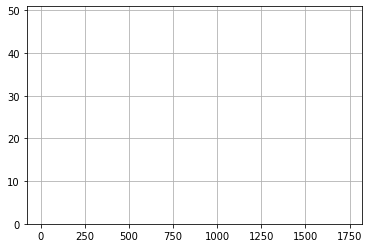

In [2175]:
ss['TST'].hist(density=True, alpha=0.5)
target['TST'].sample(780).hist(density=True, alpha=0.5)

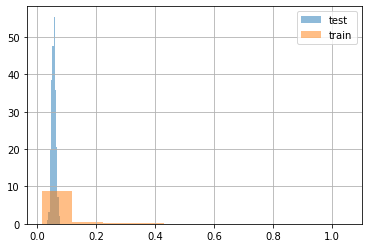

In [2176]:
ss['C'].hist(density=True, alpha=0.5)
target['C'].sample(500).hist(density=True, alpha=0.5)
plt.legend(['test', 'train'])

In [1982]:
test_dates = chronom.groupby('NPLV')['VR_NACH'].last().dt.date

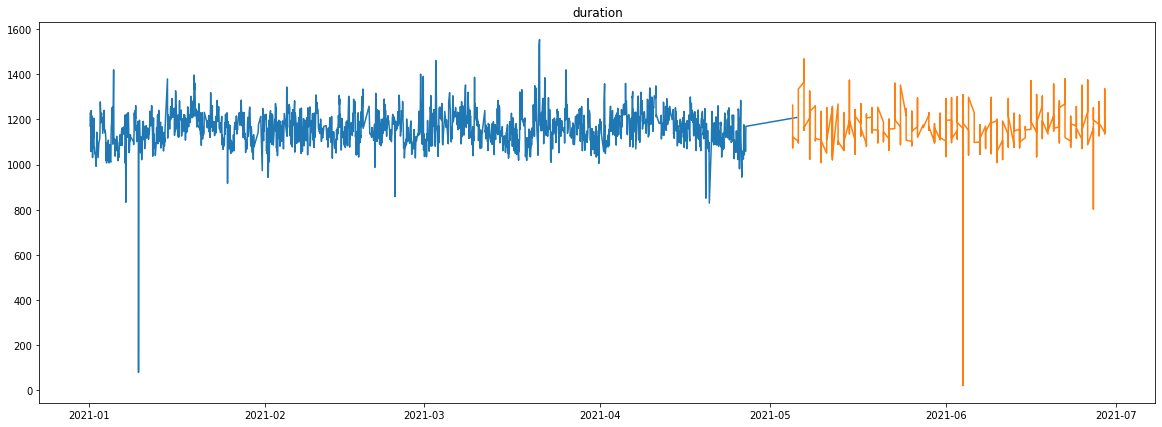

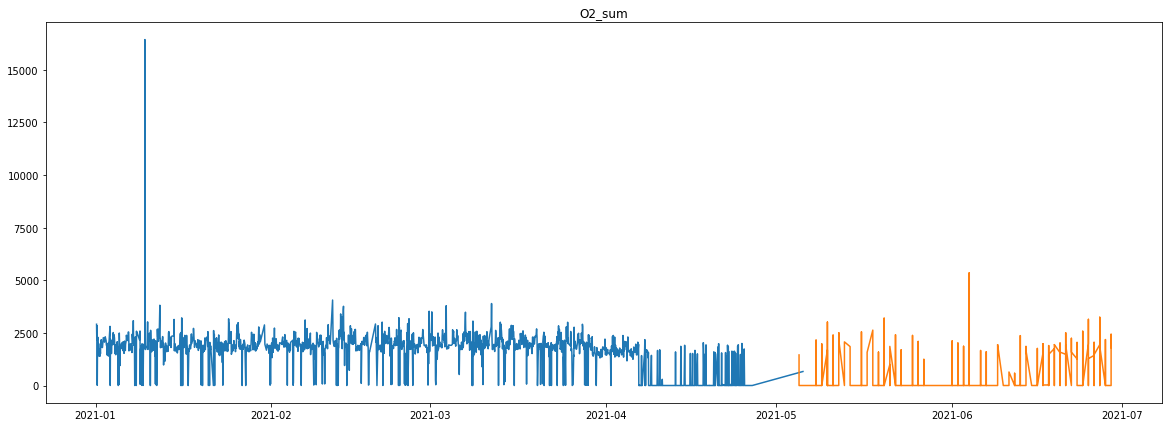

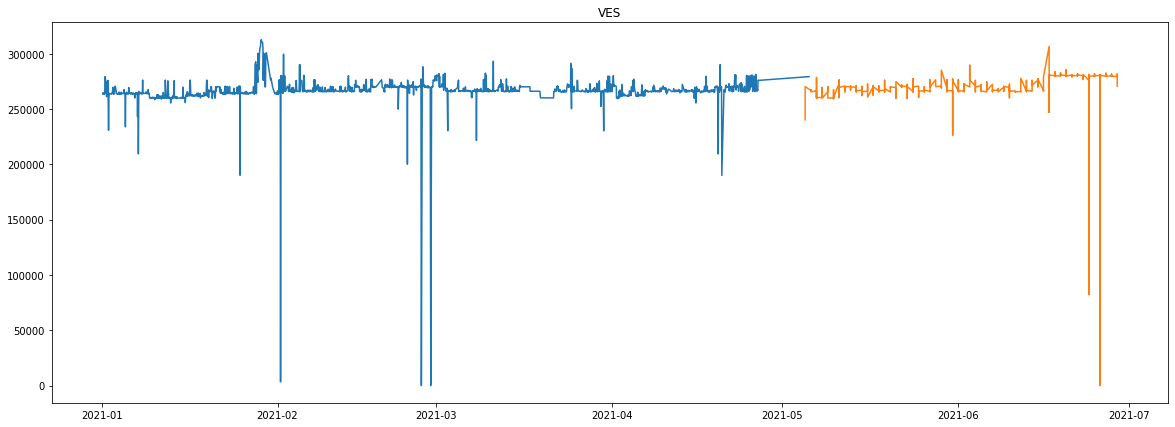

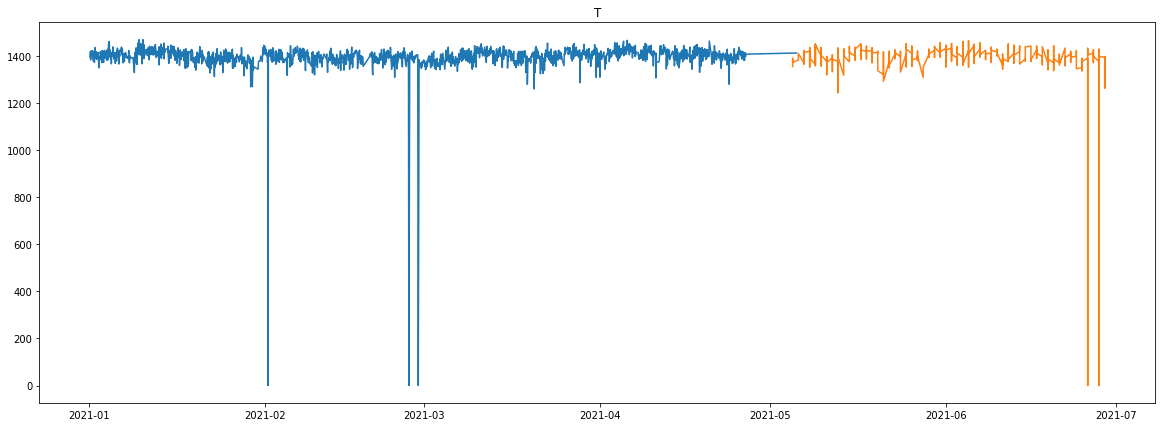

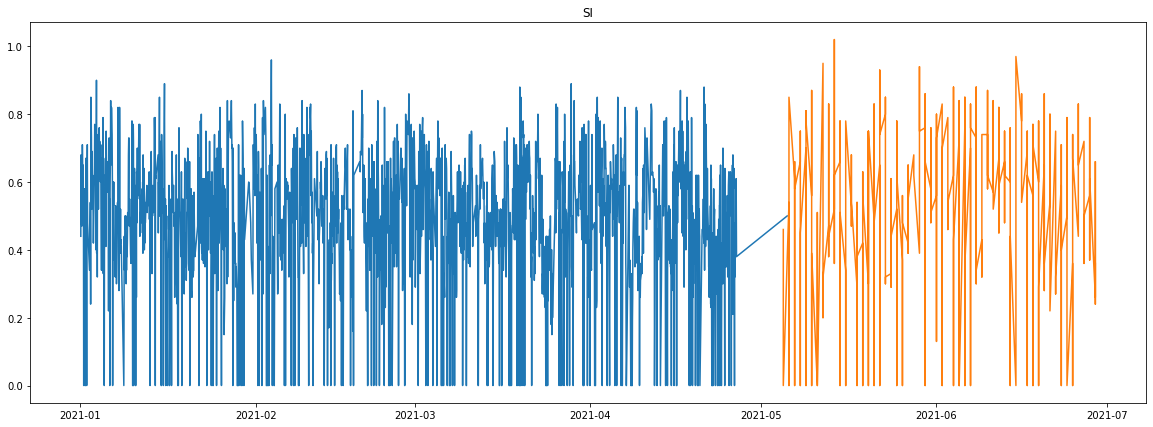

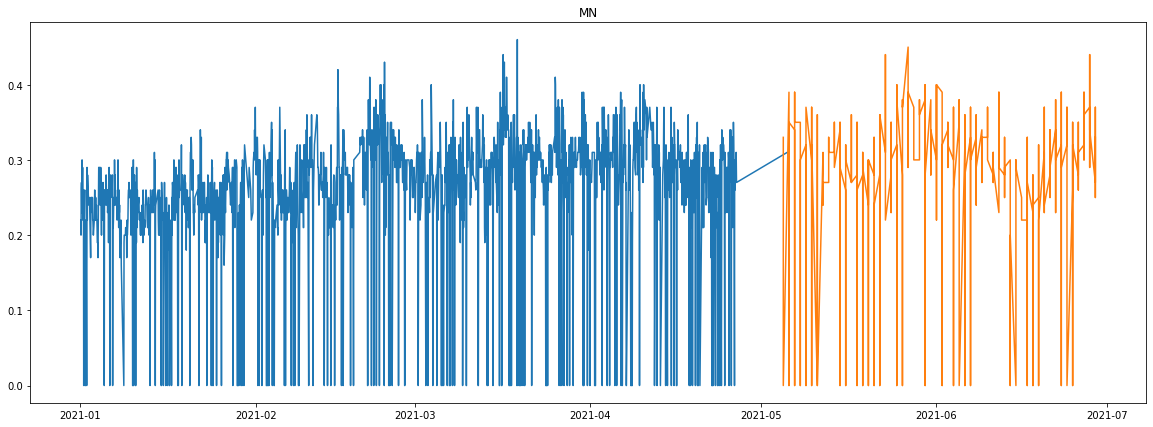

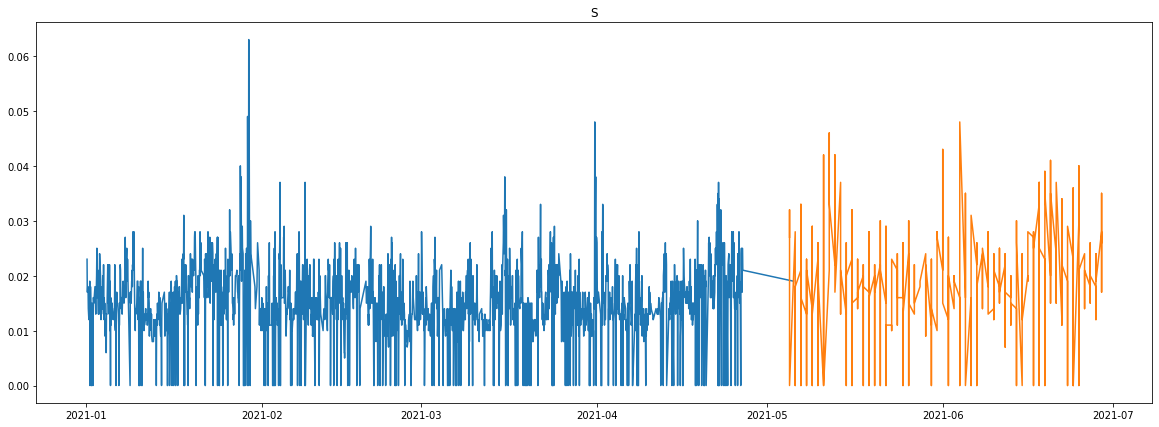

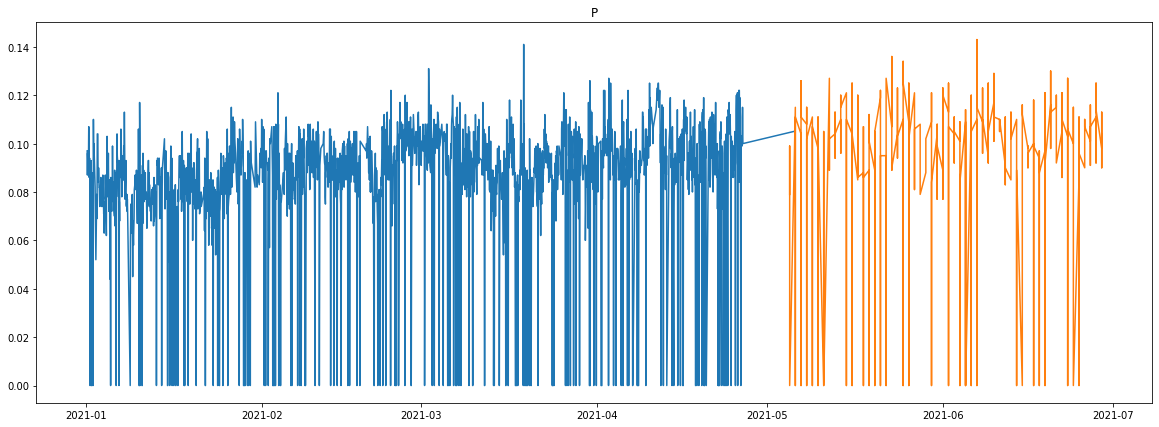

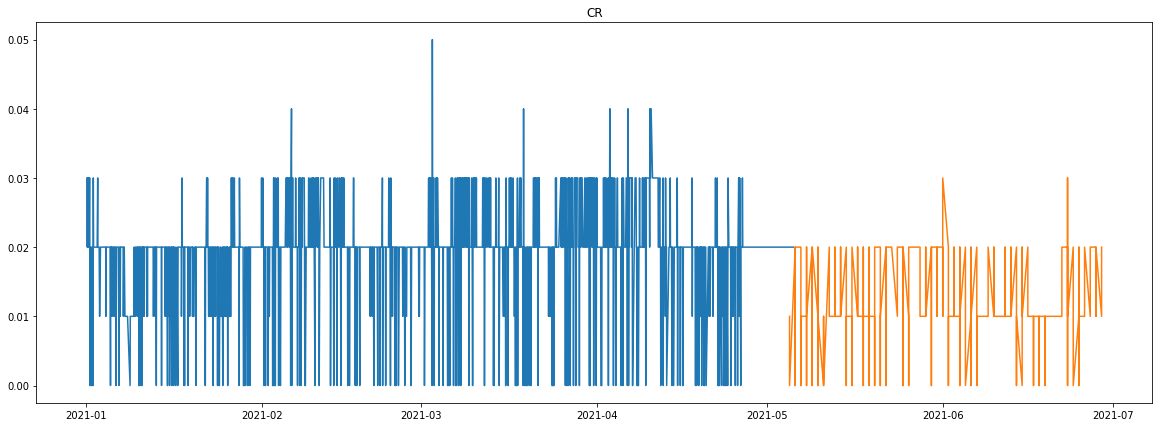

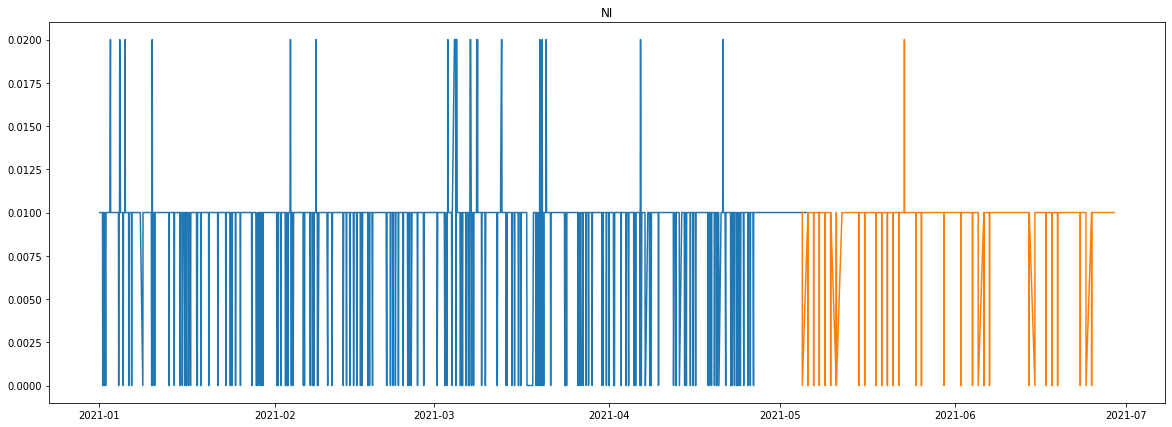

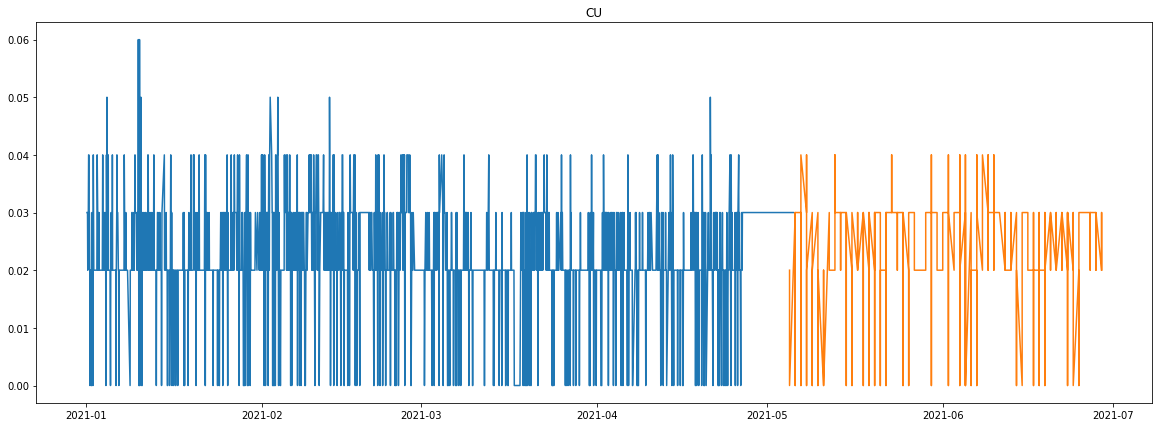

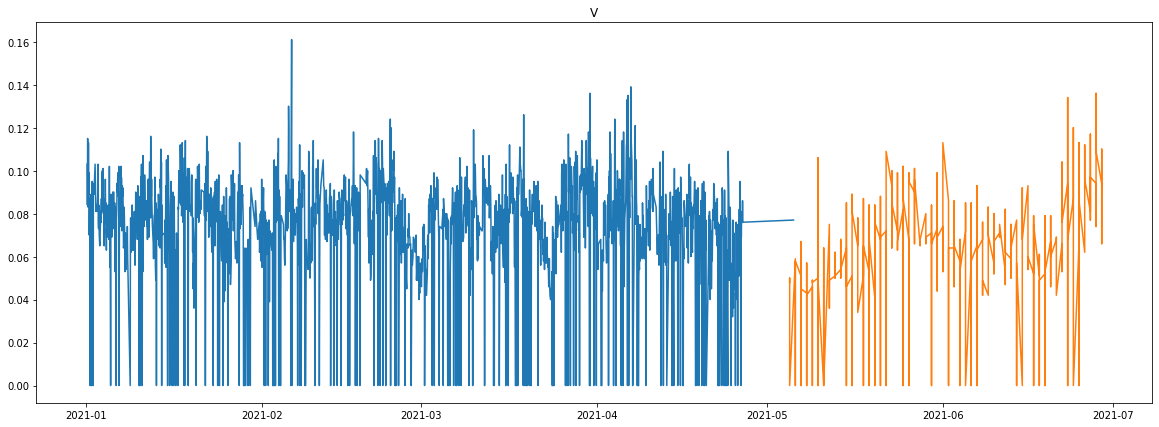

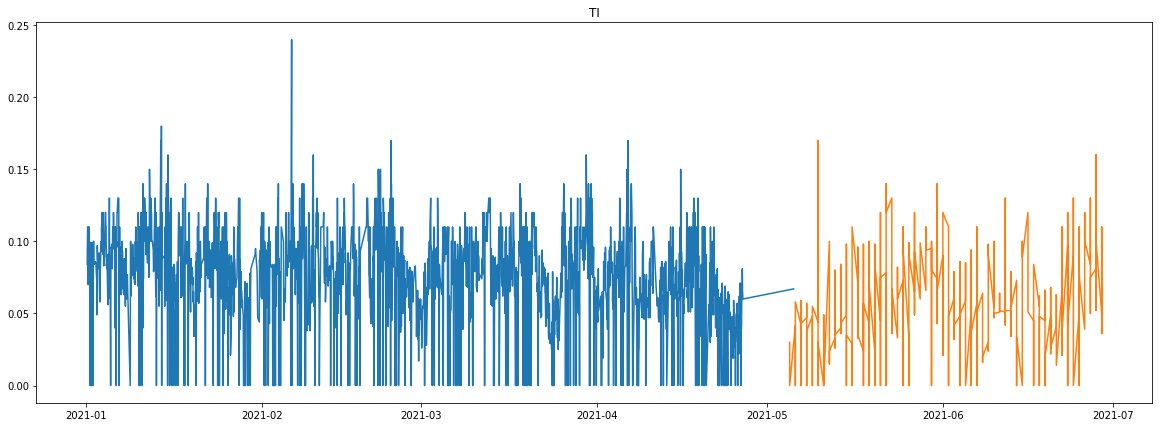

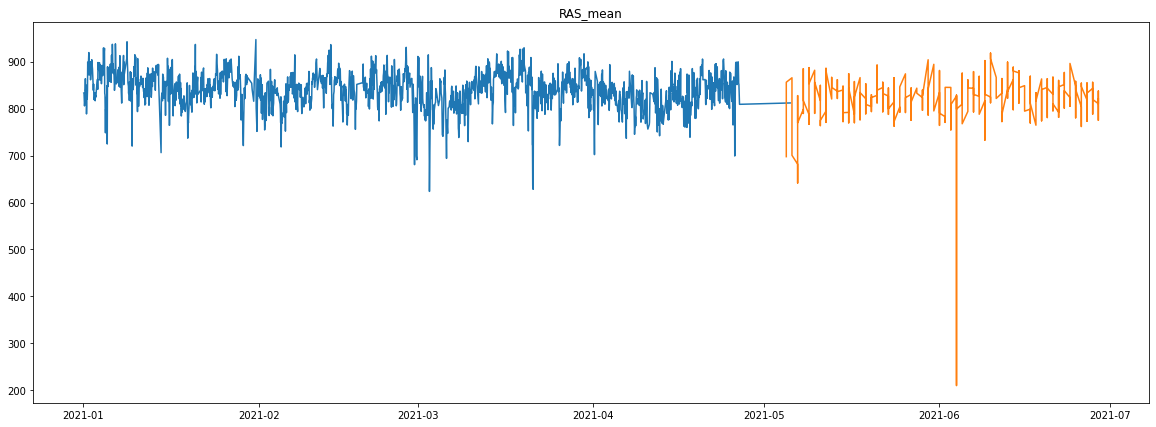

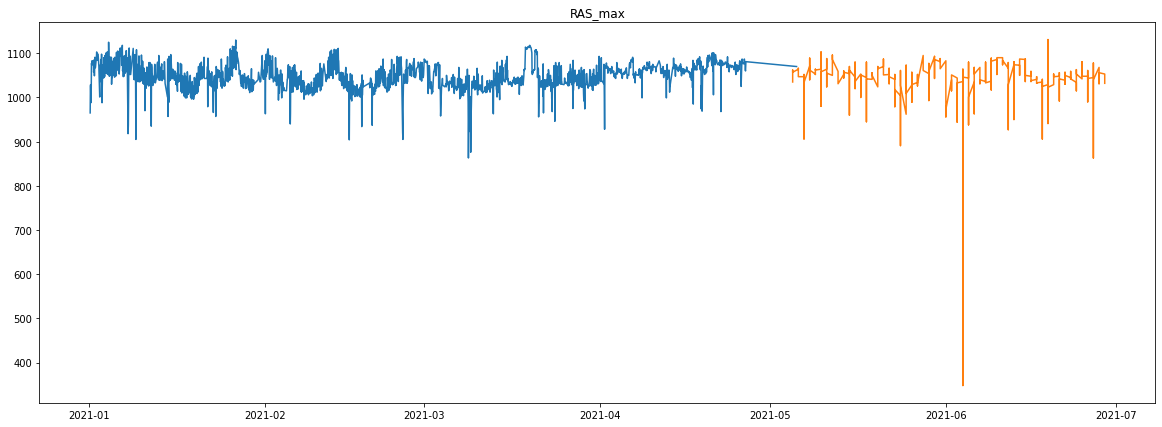

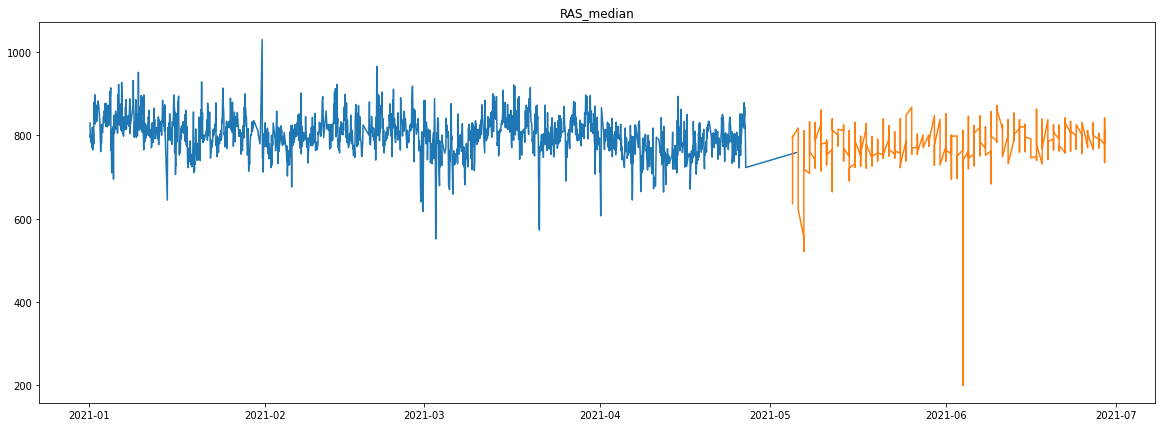

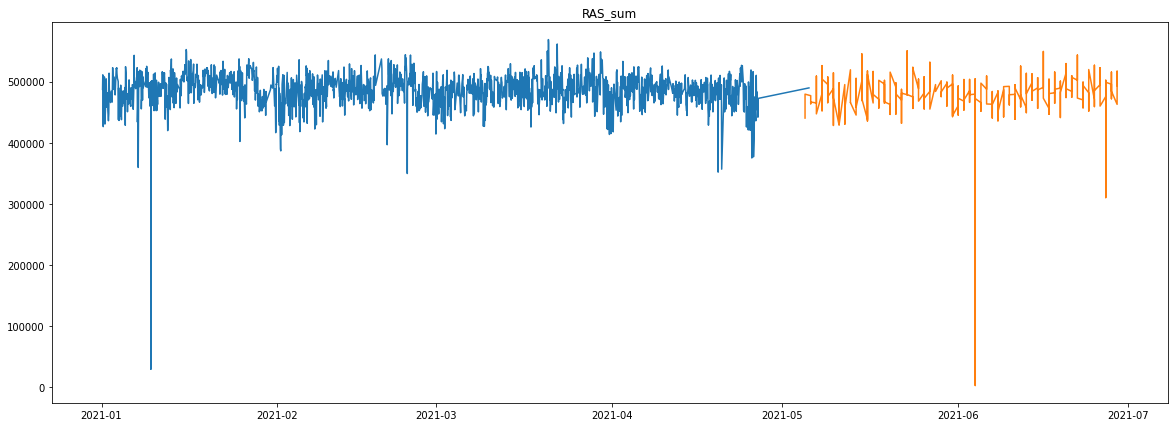

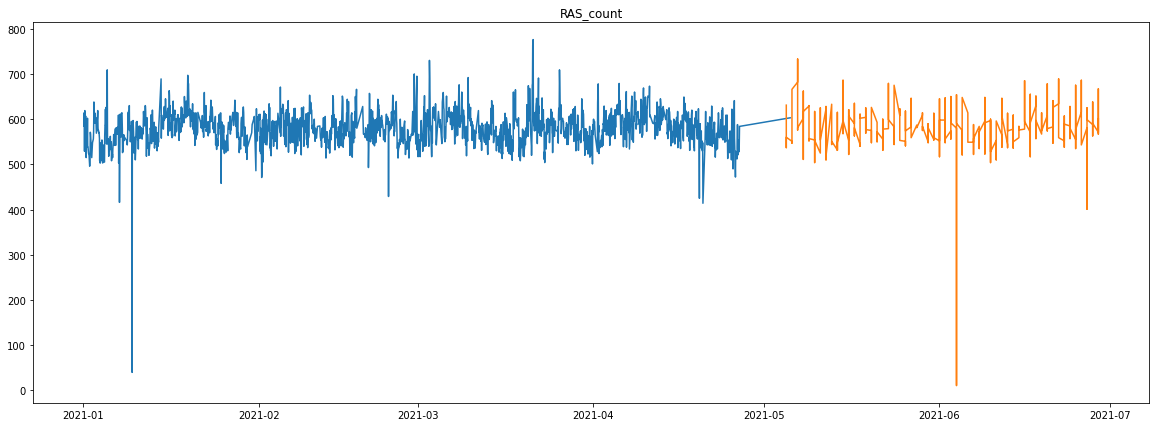

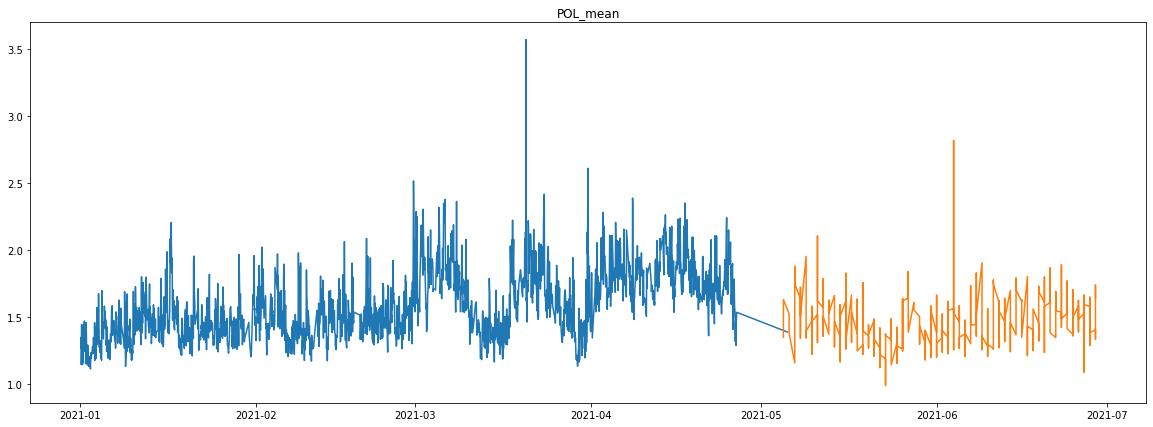

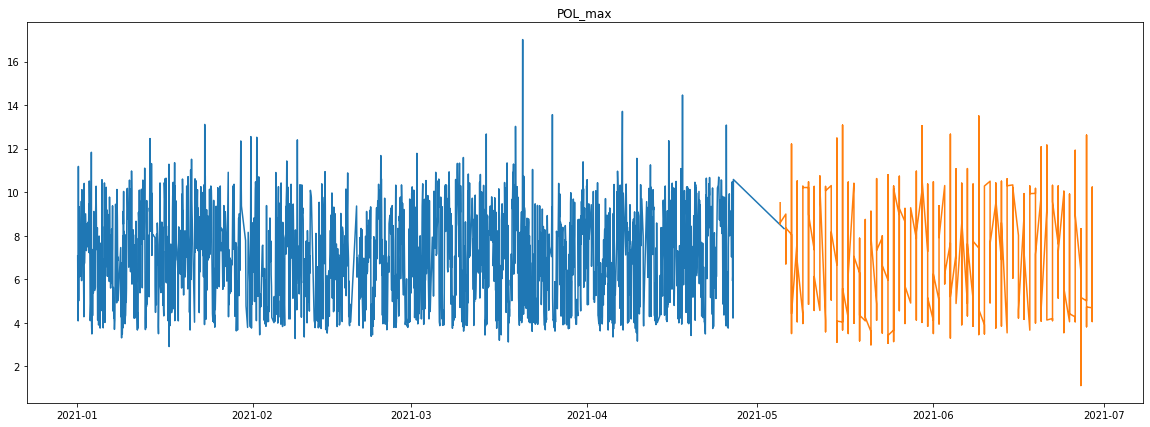

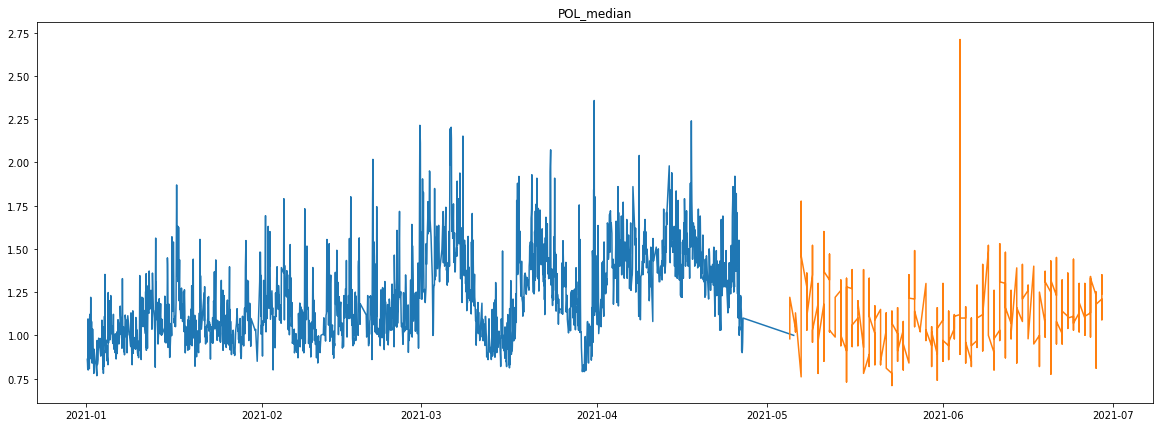

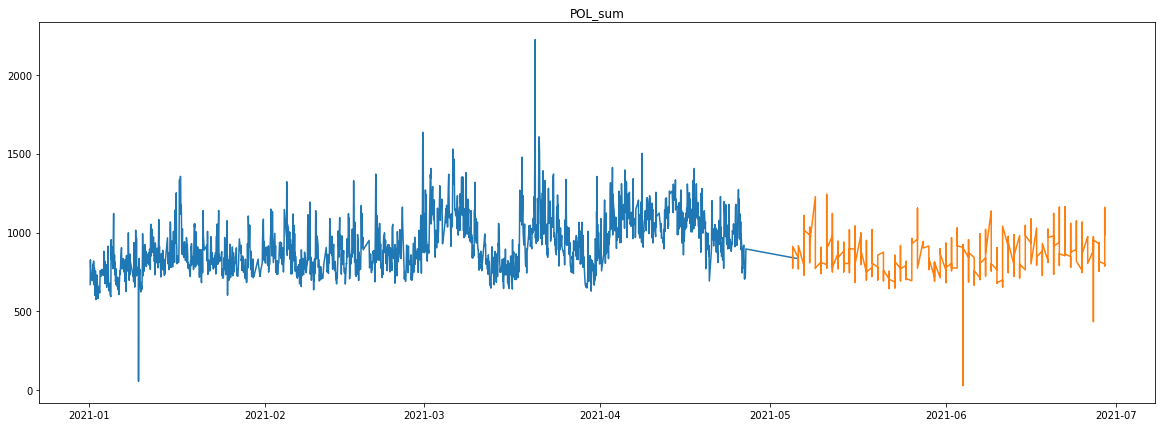

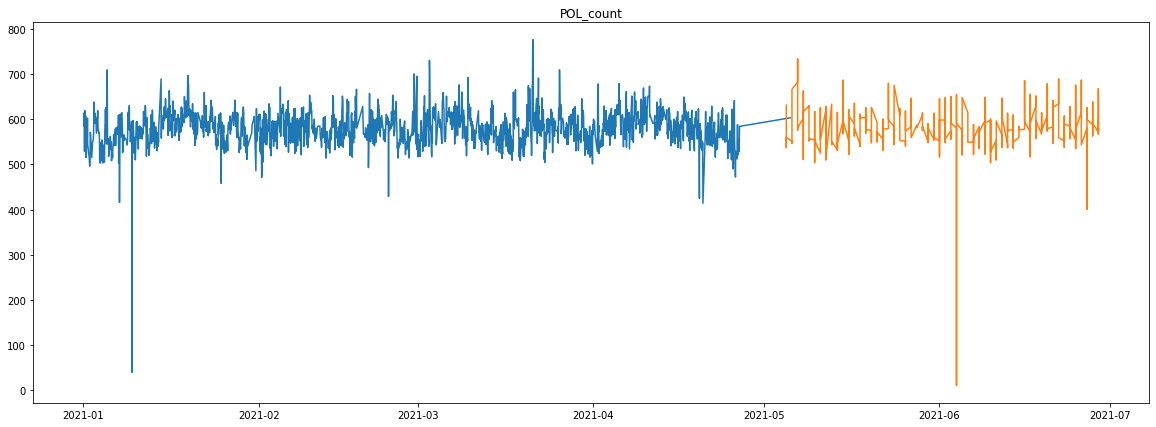

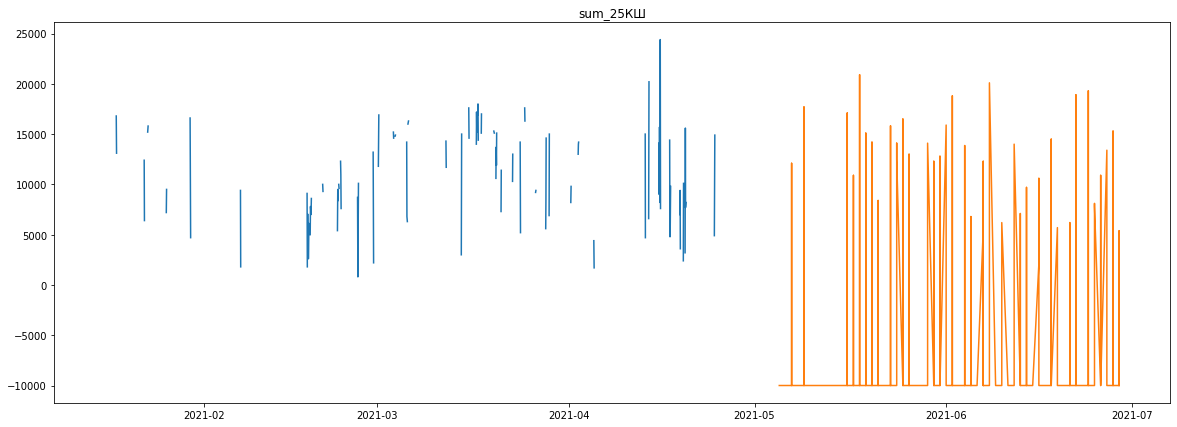

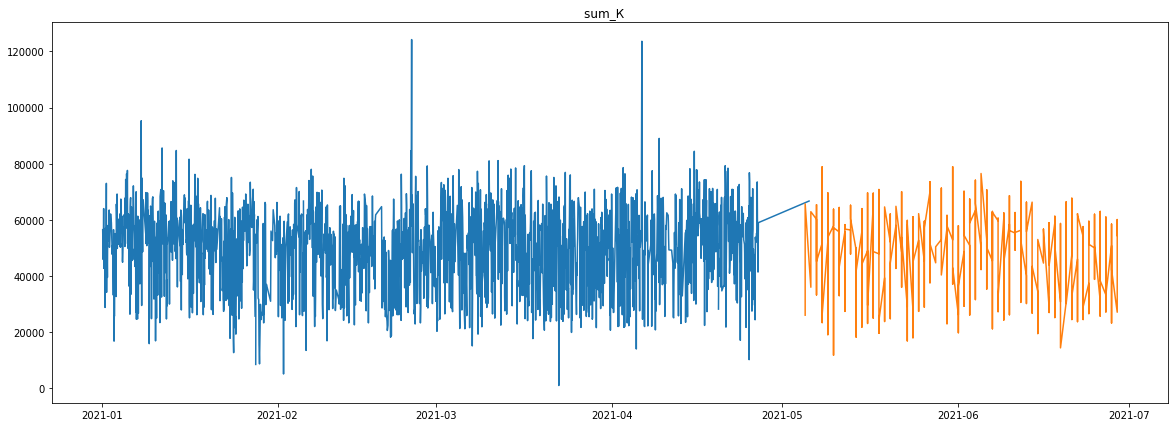

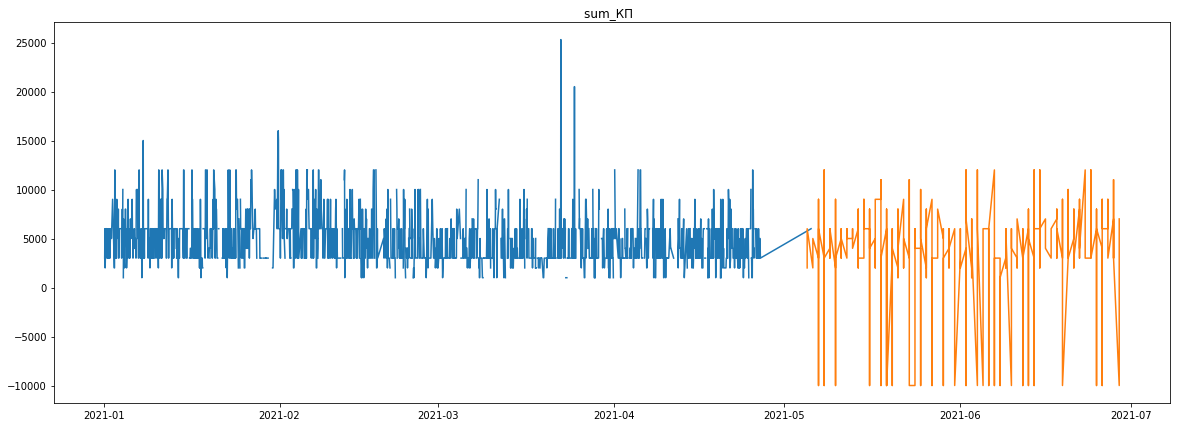

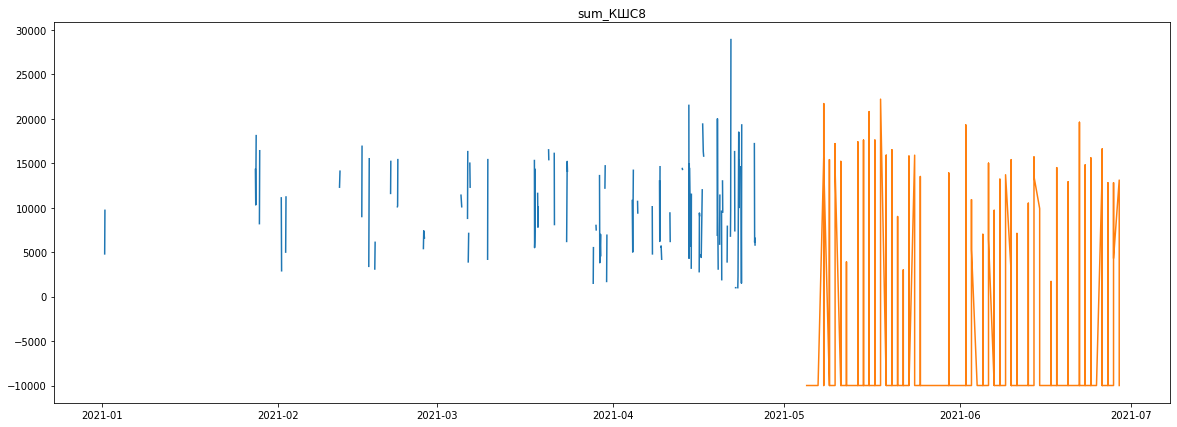

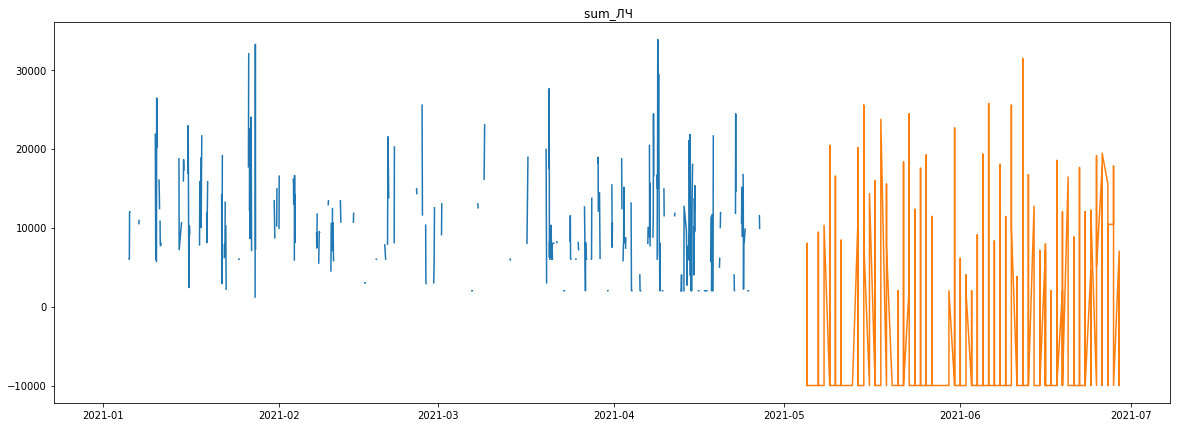

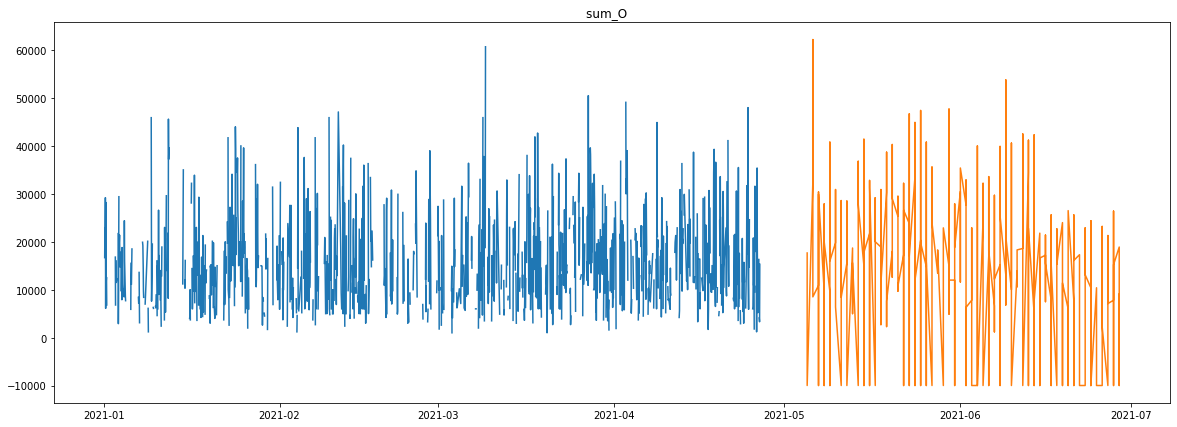

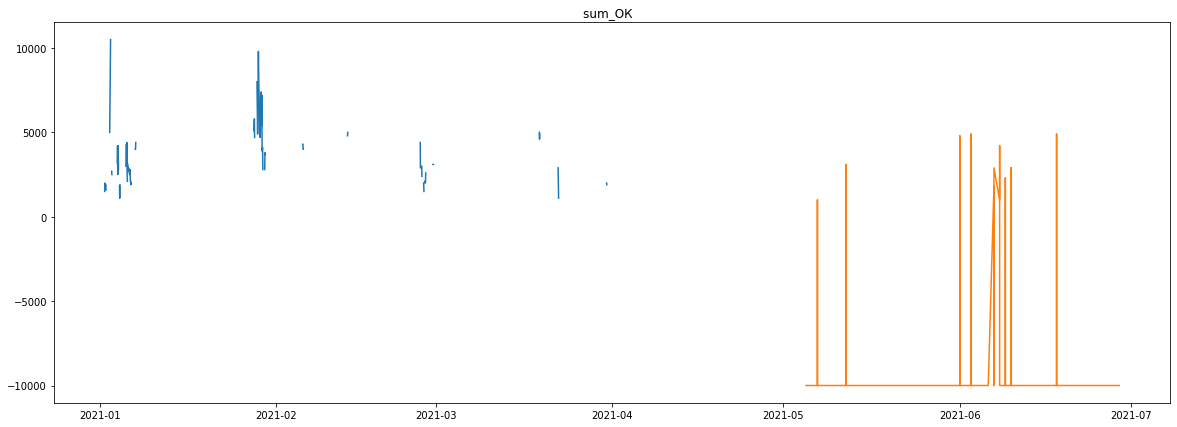

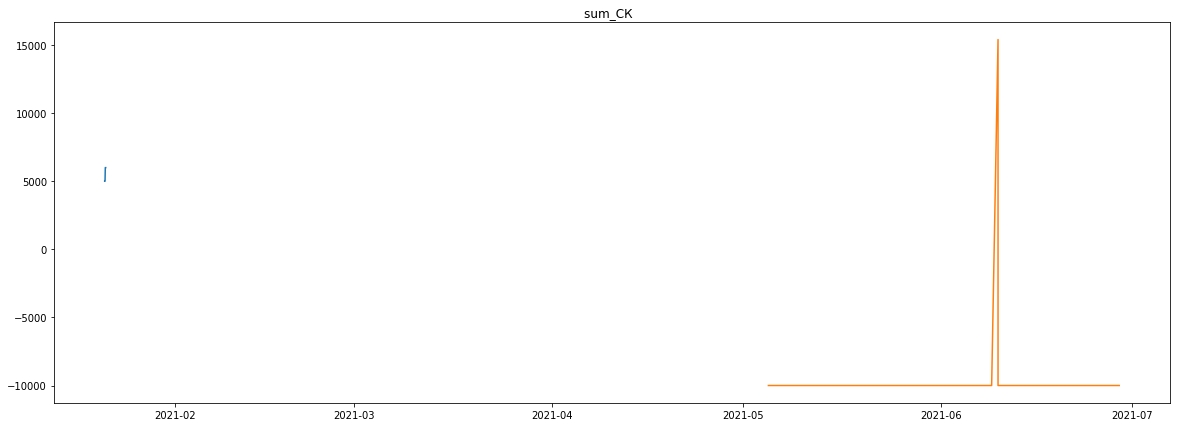

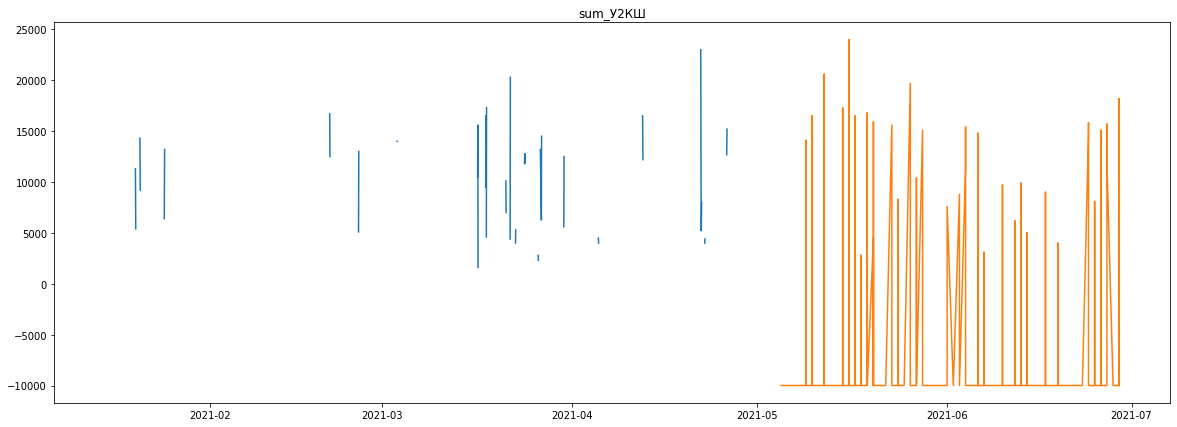

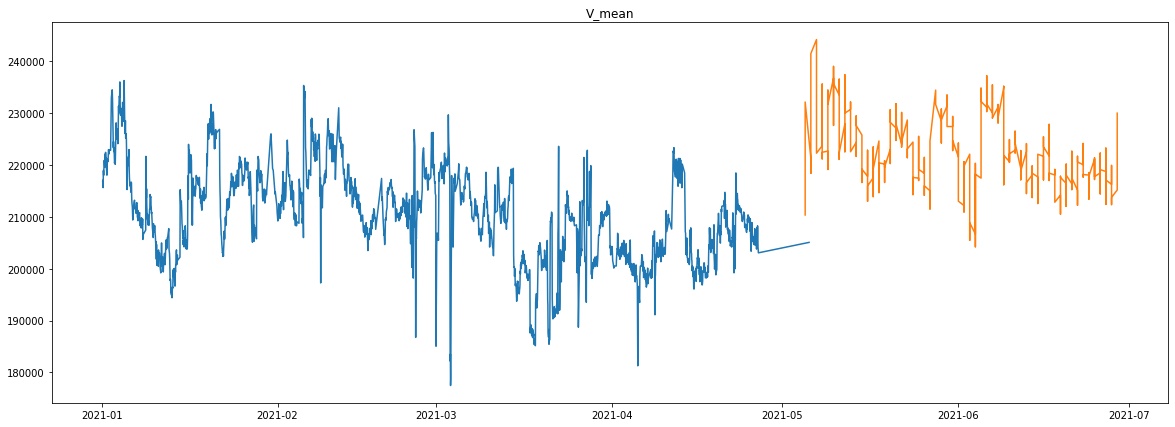

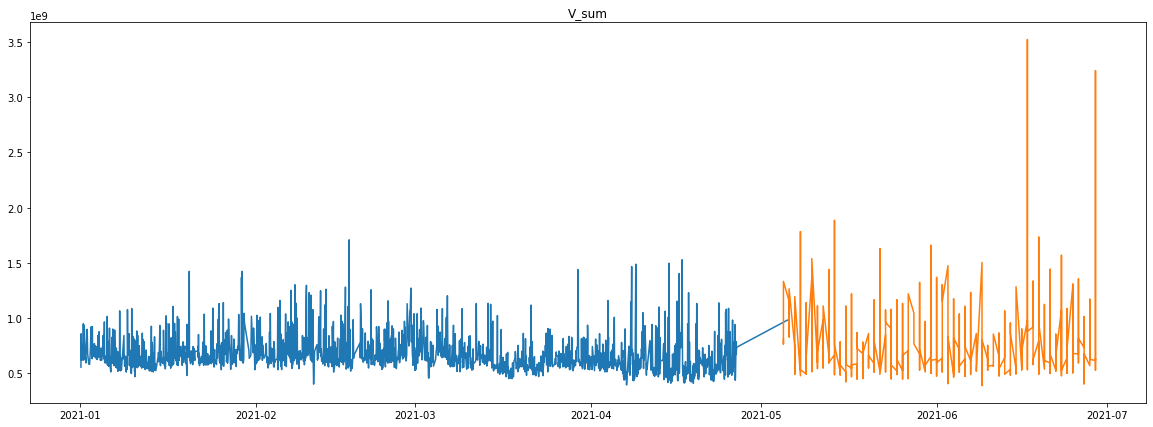

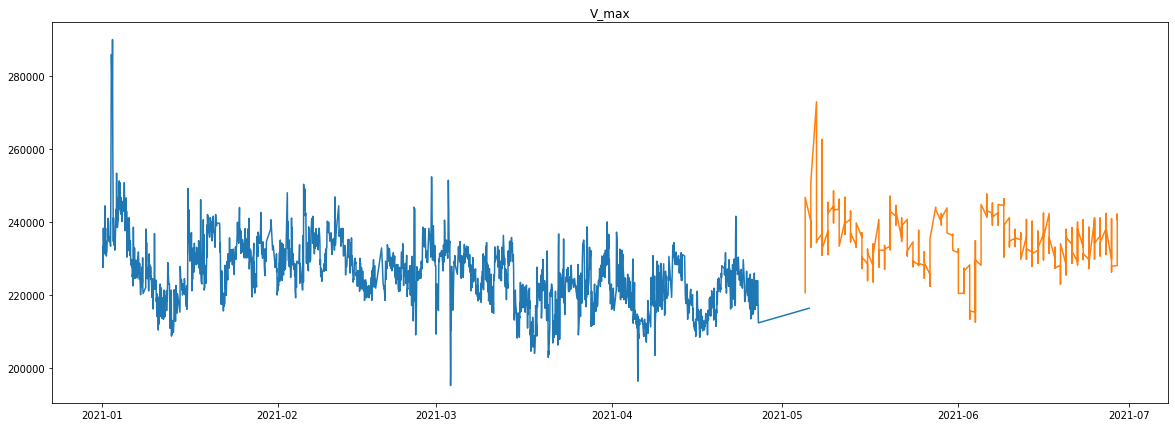

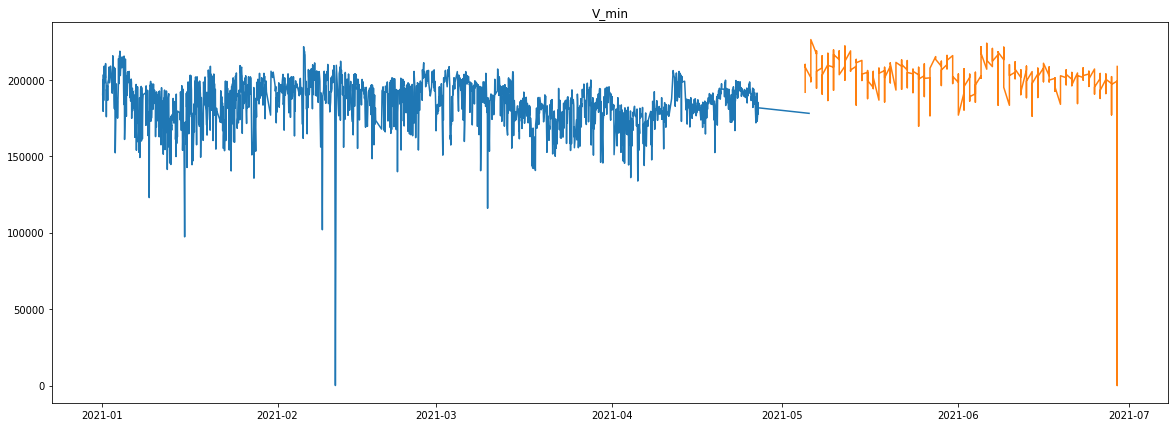

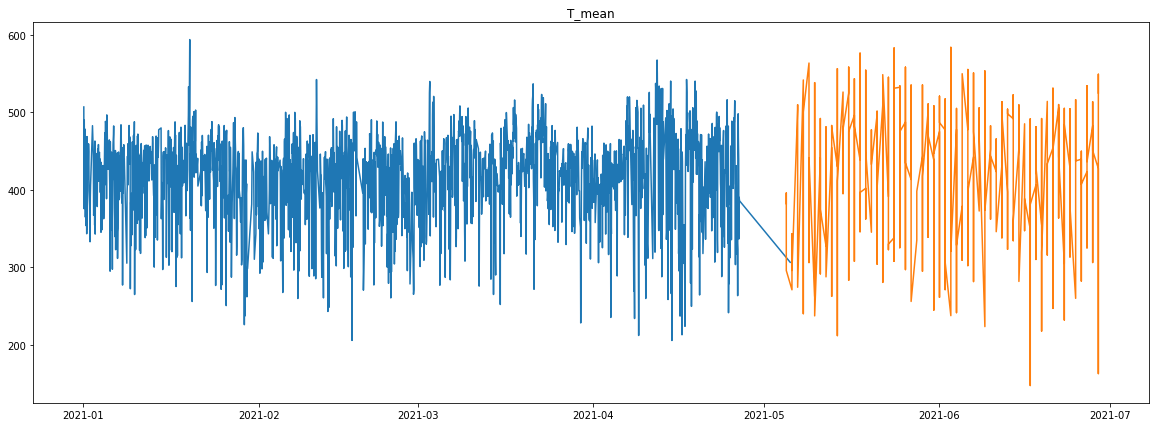

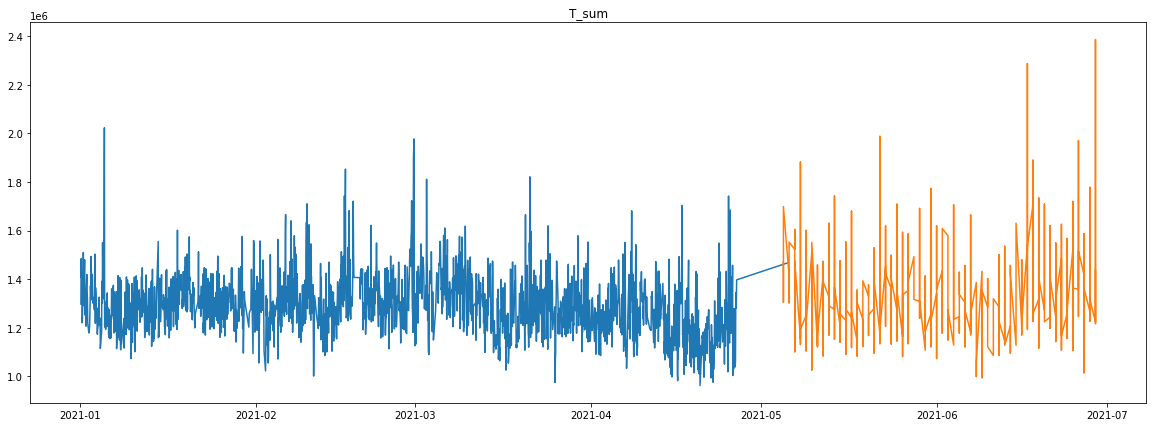

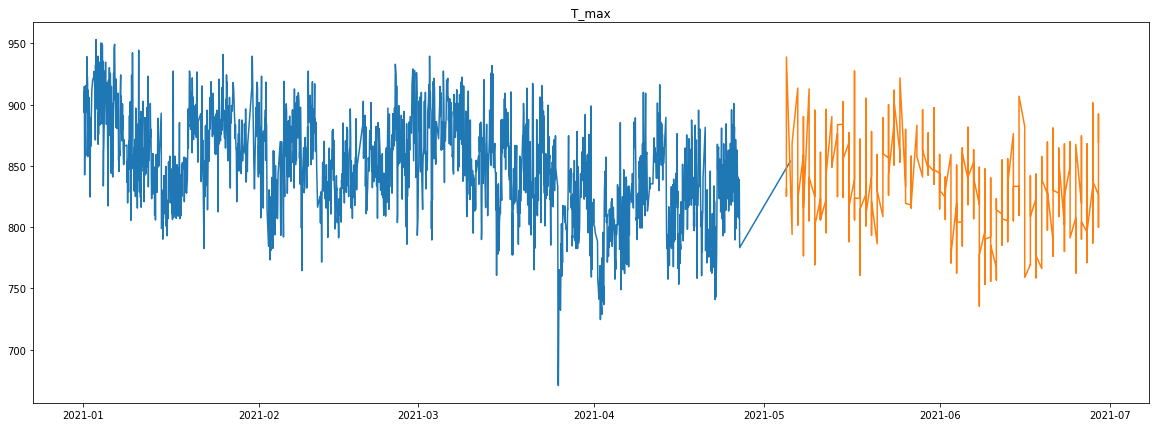

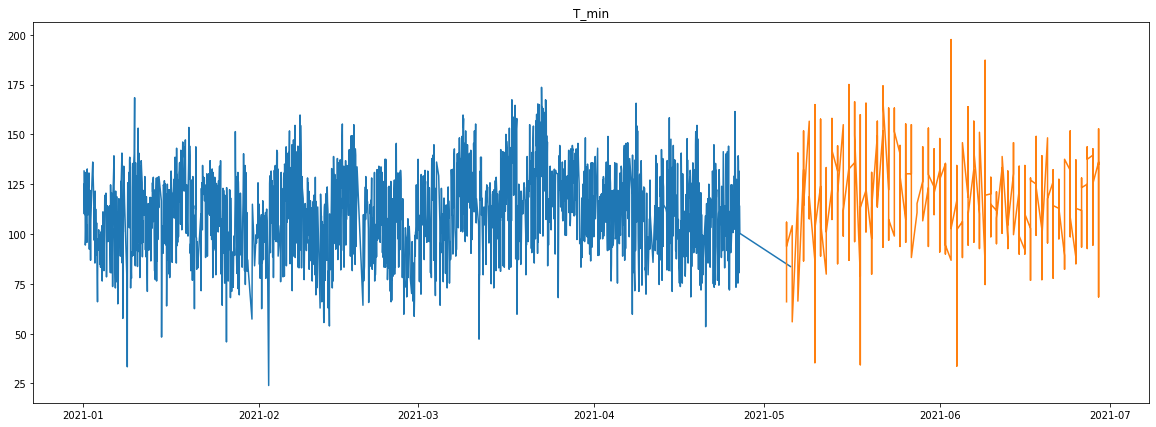

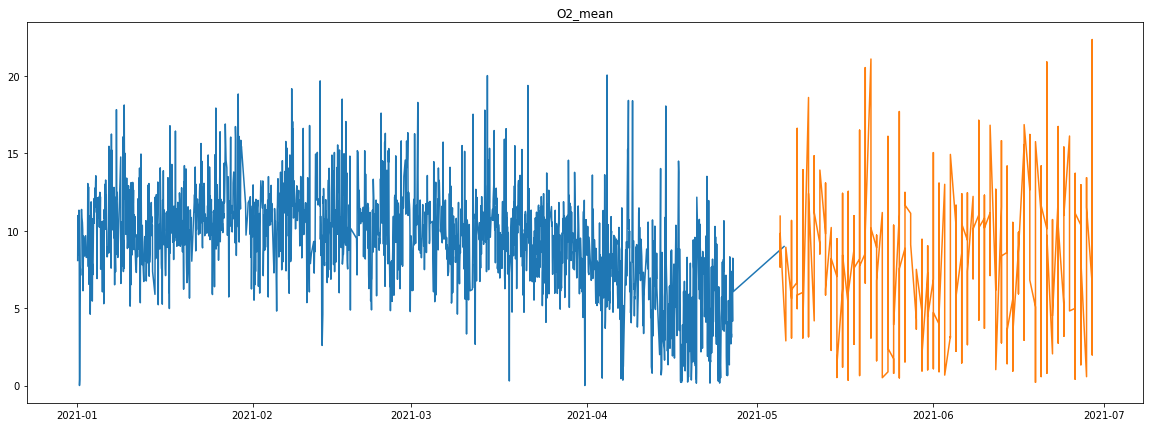

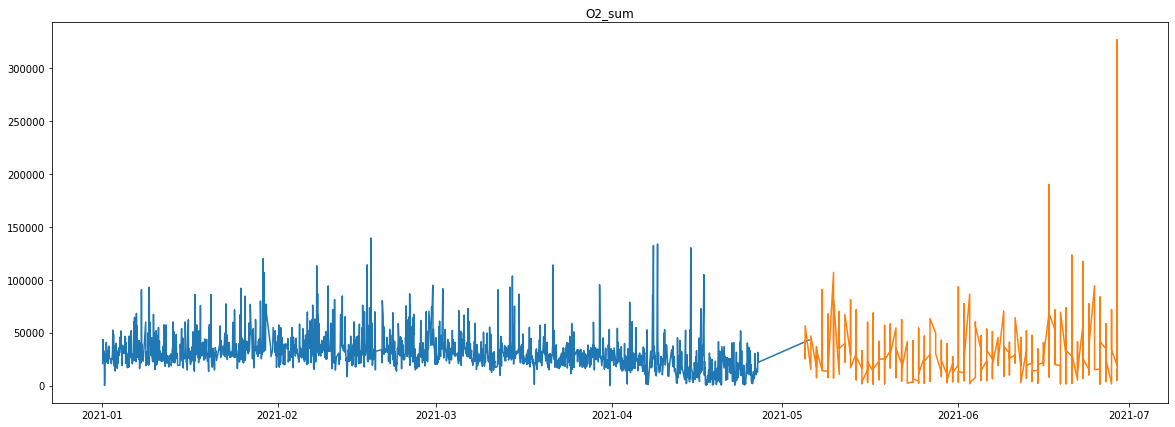

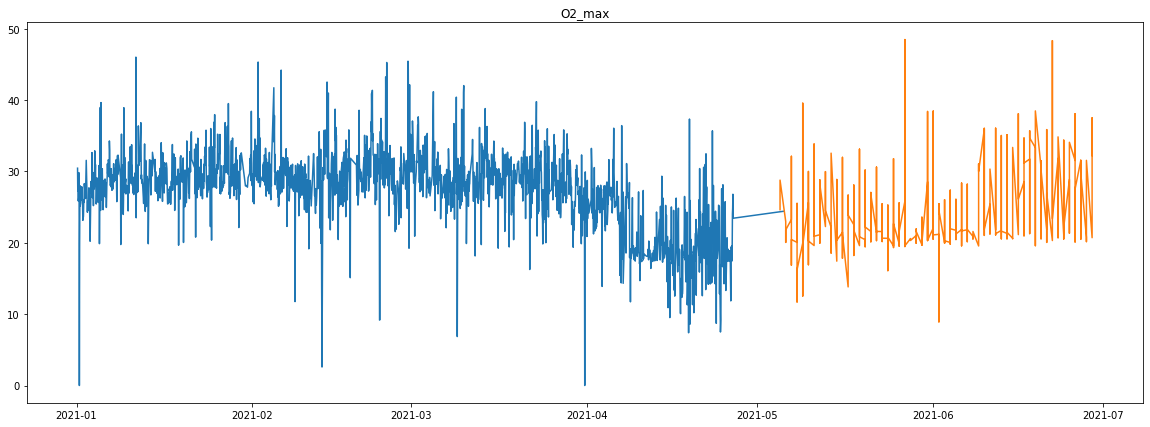

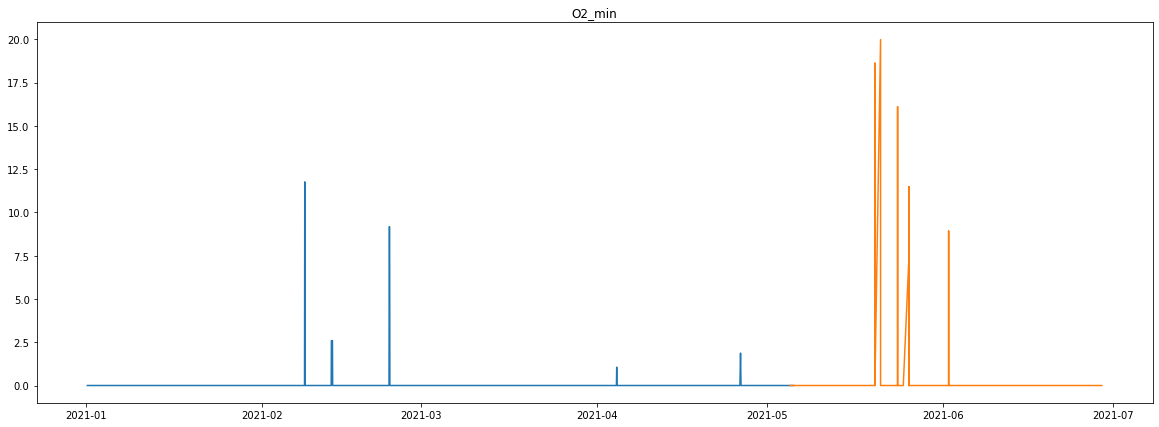

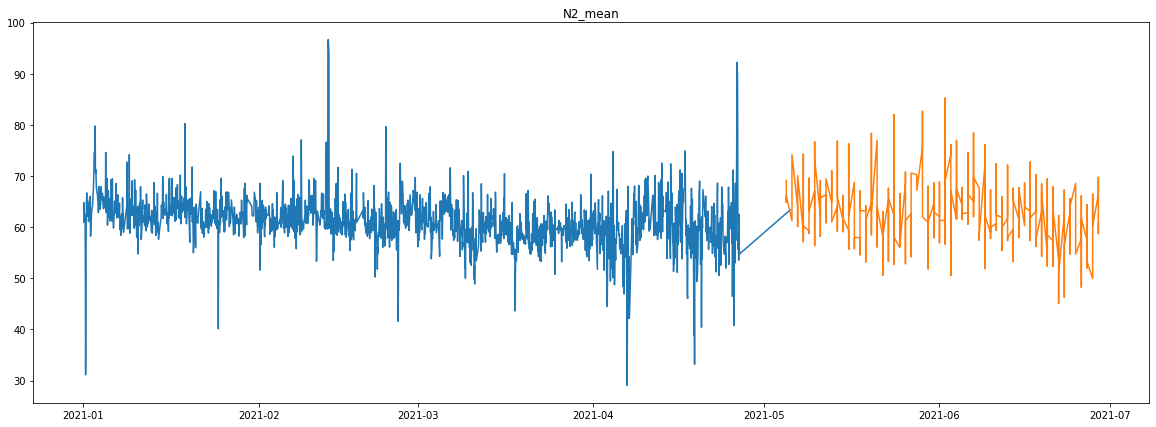

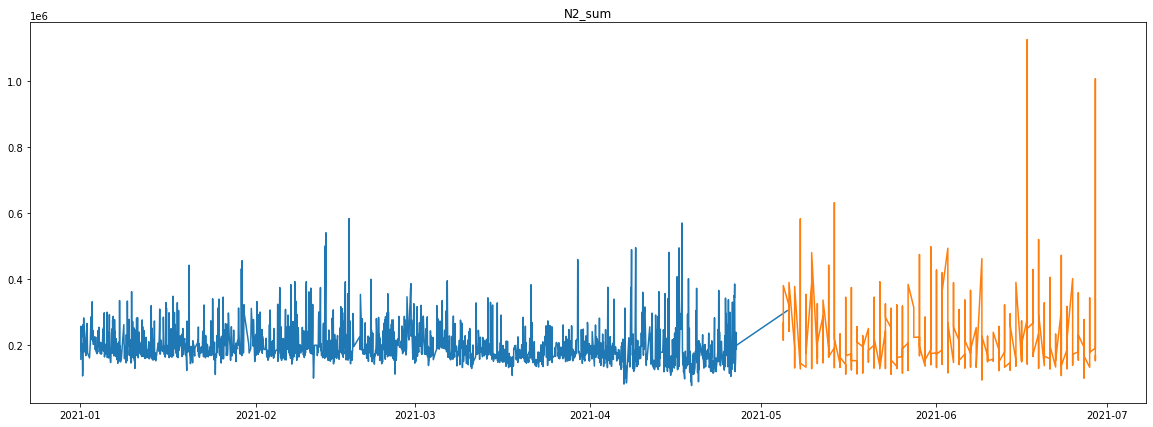

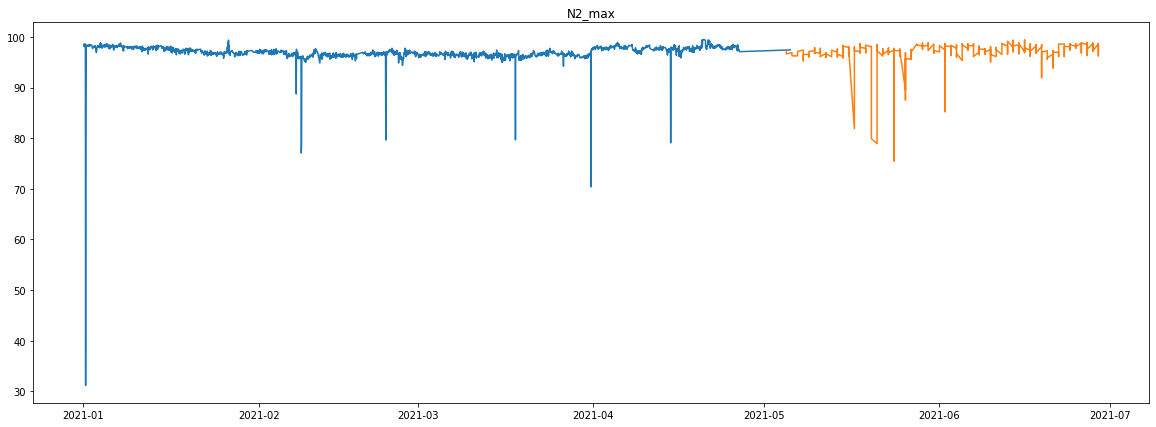

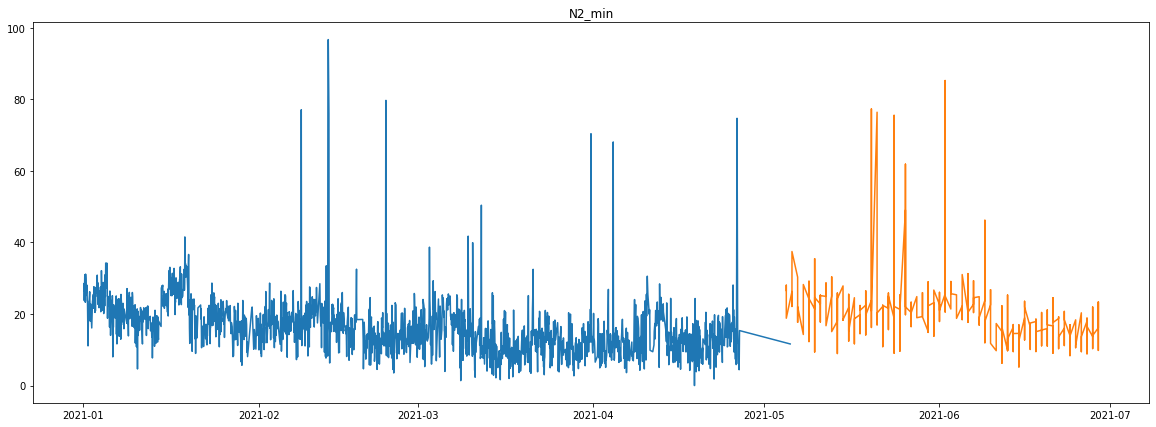

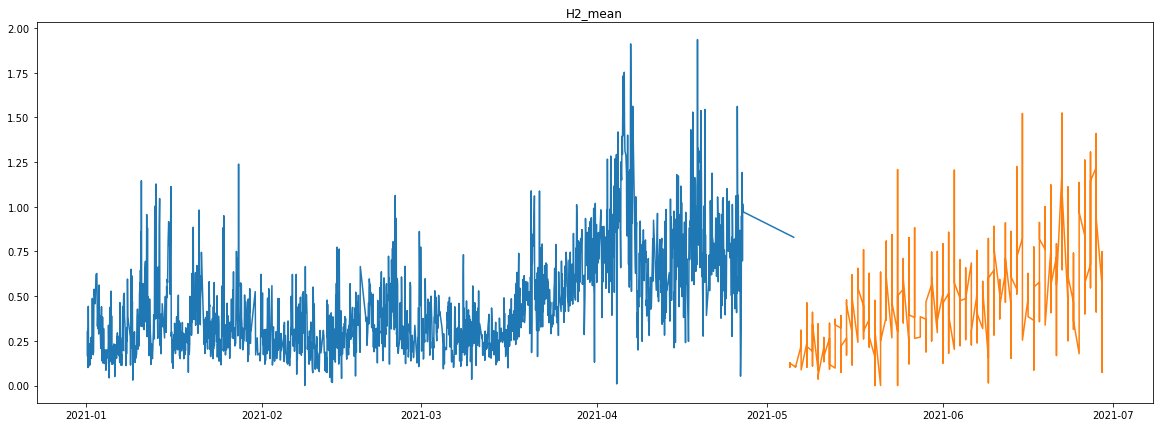

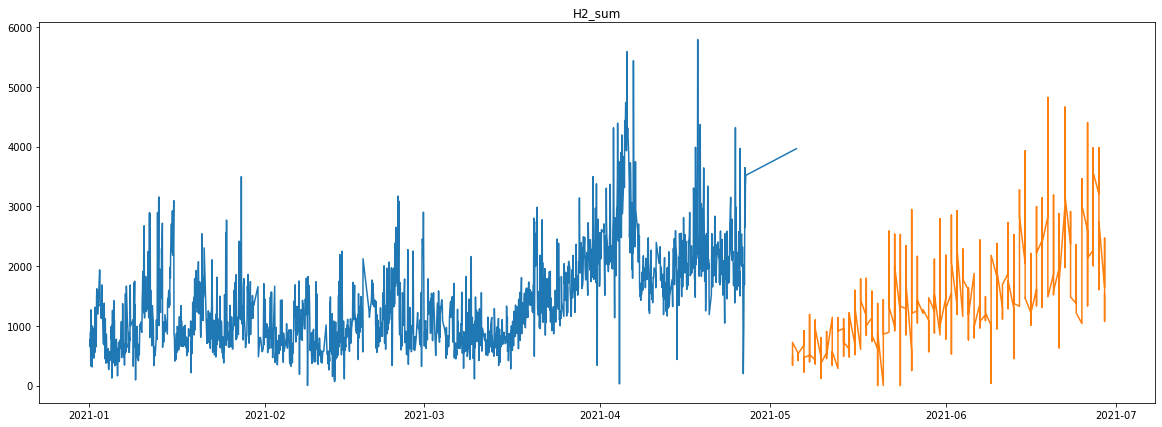

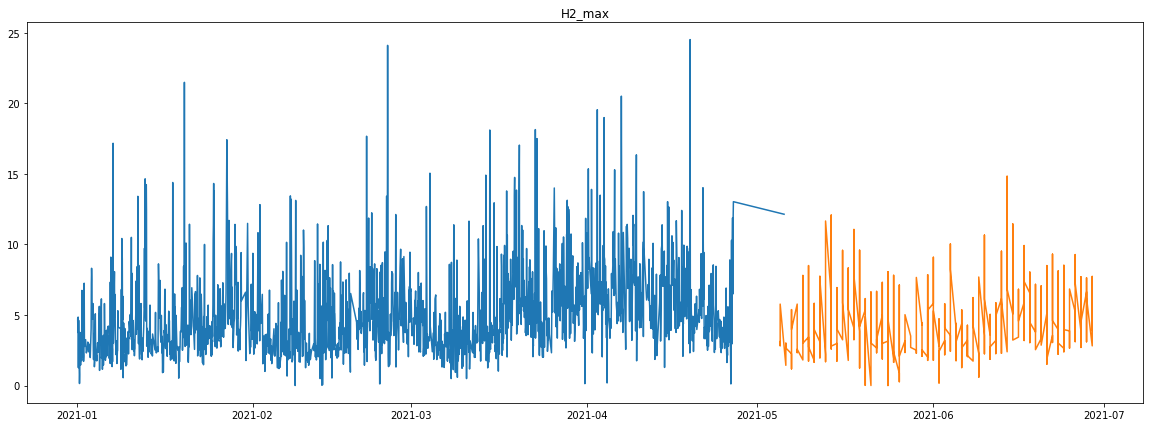

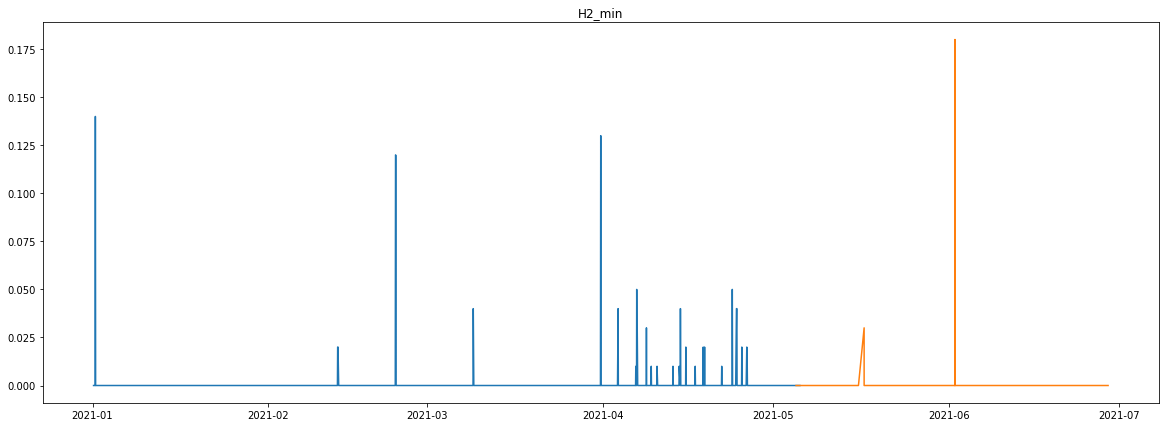

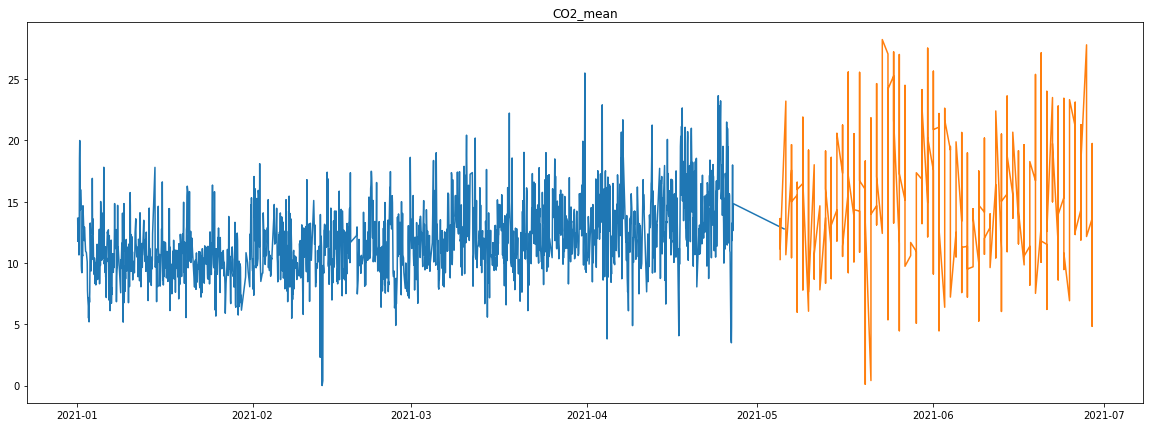

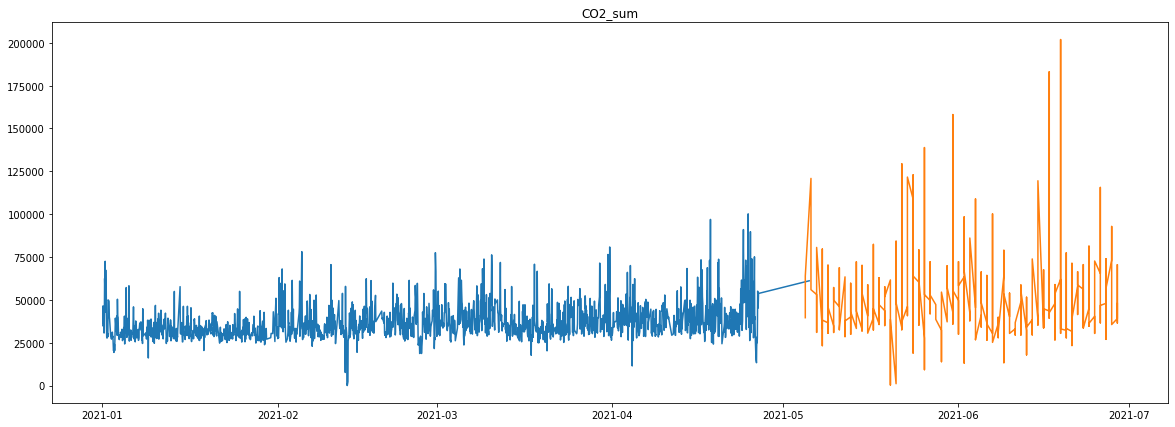

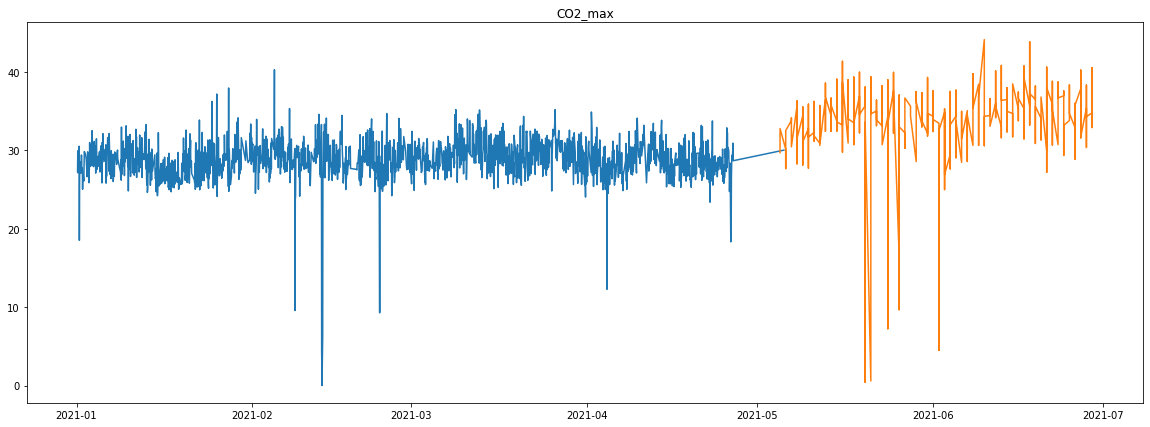

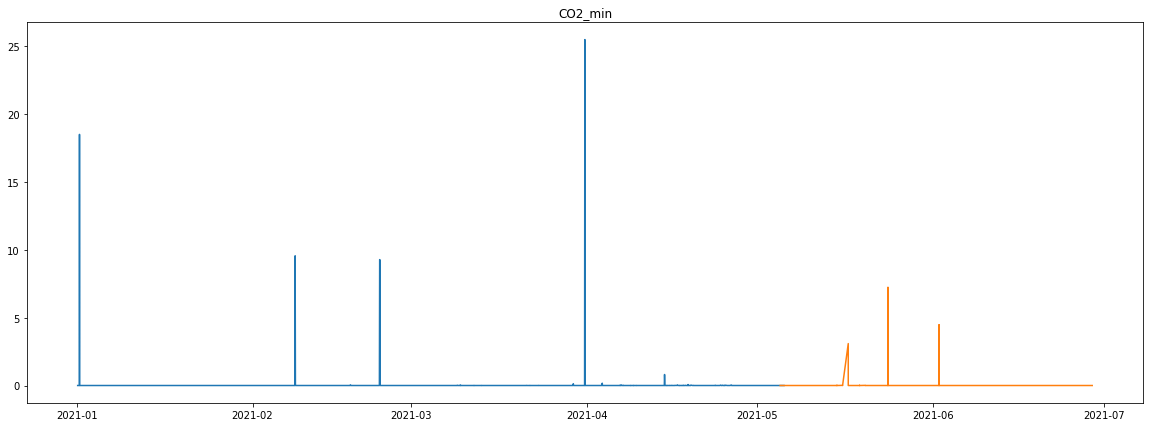

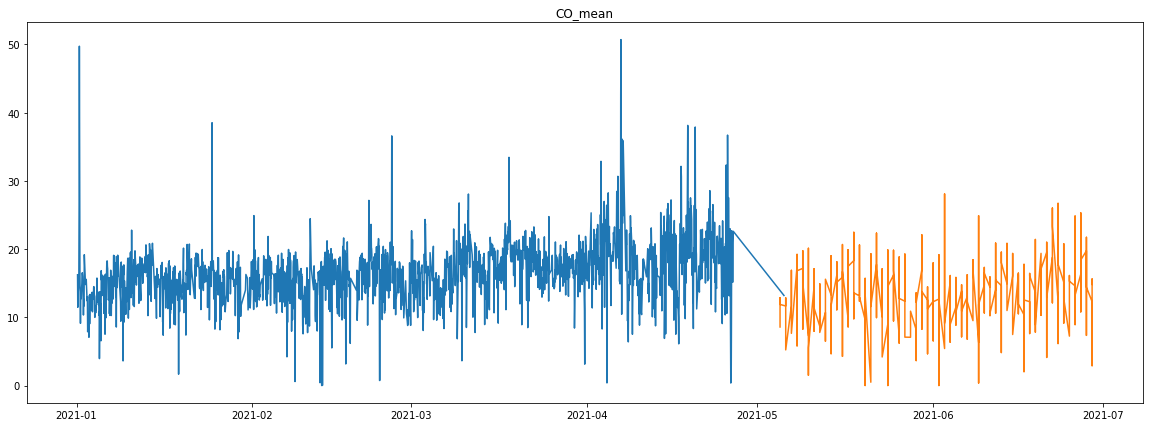

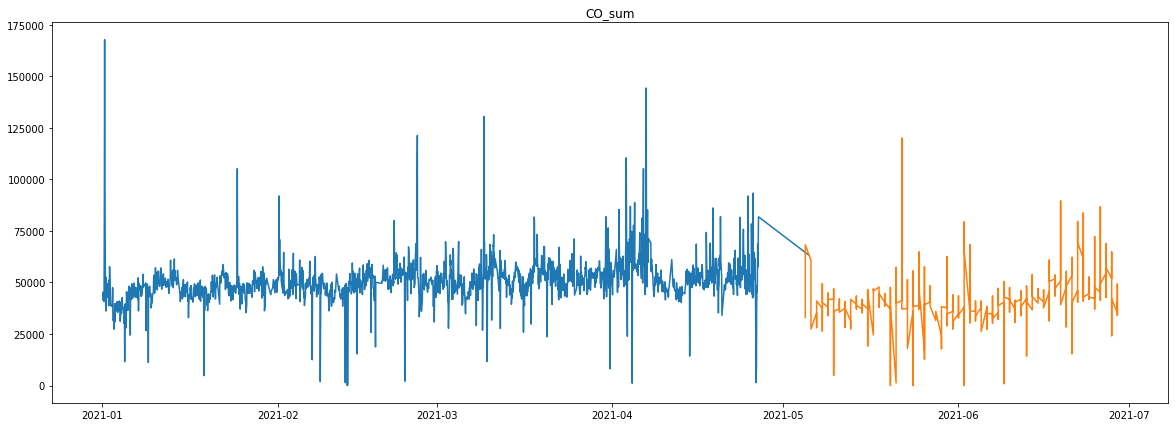

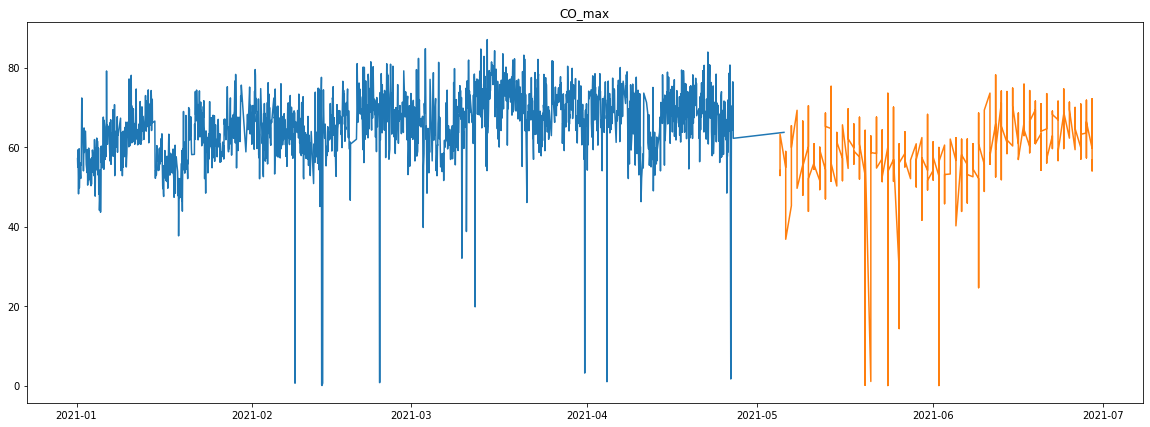

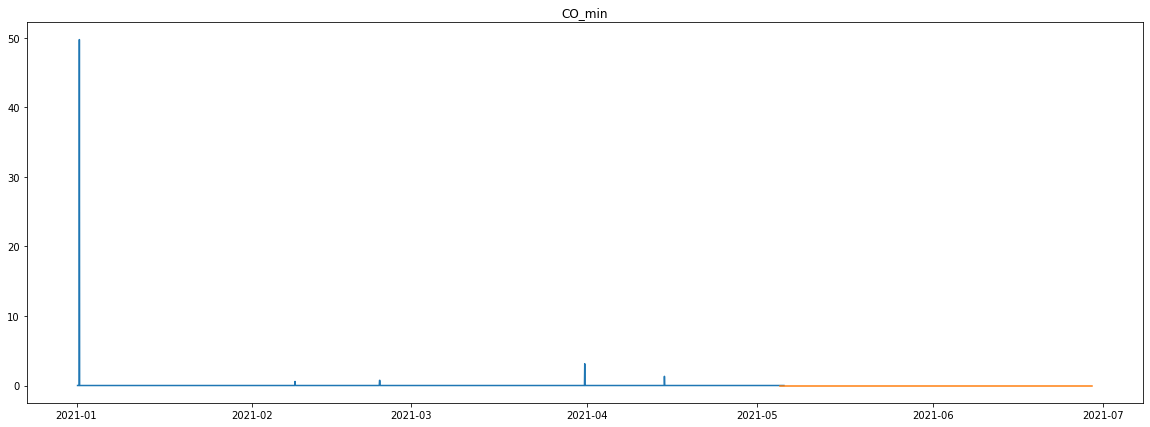

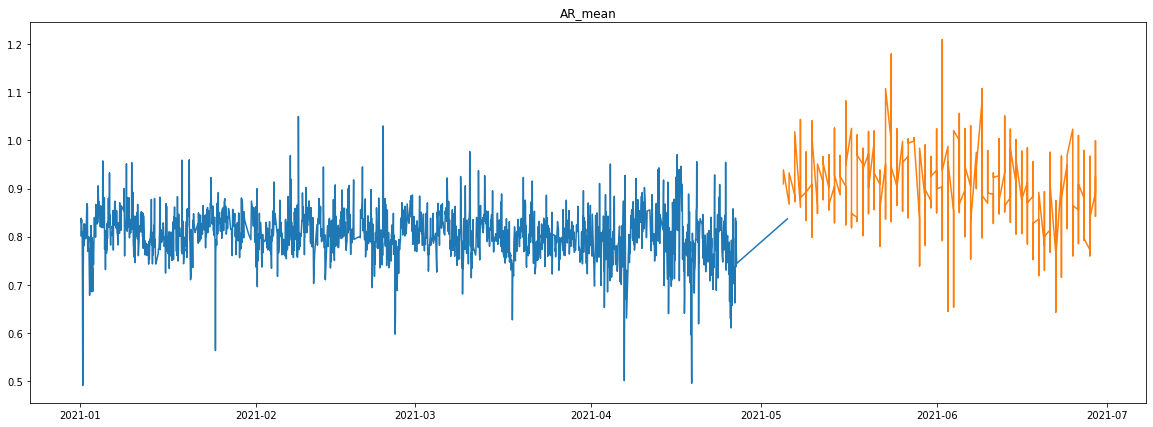

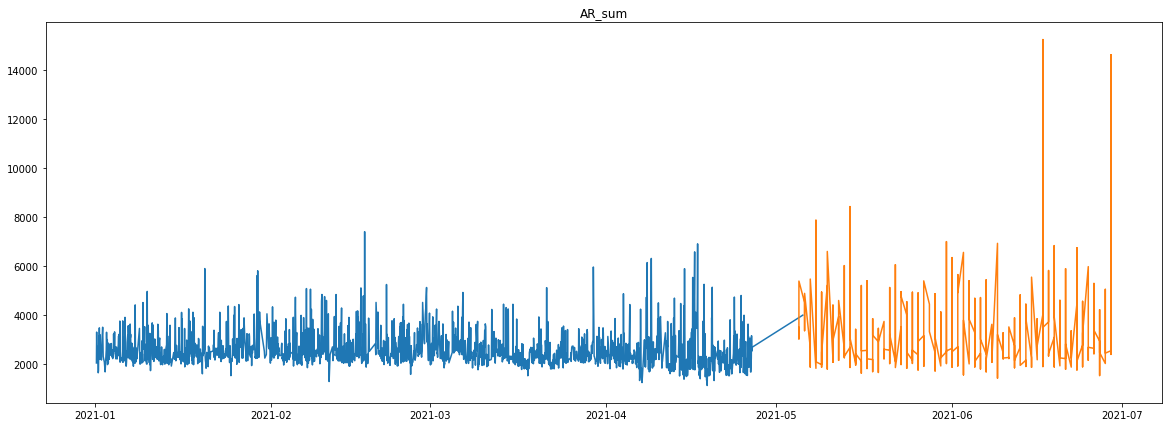

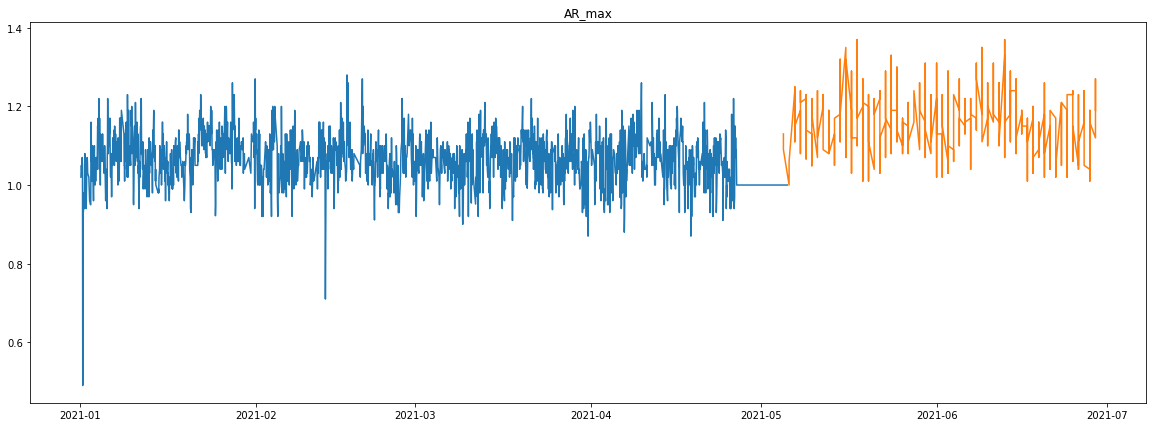

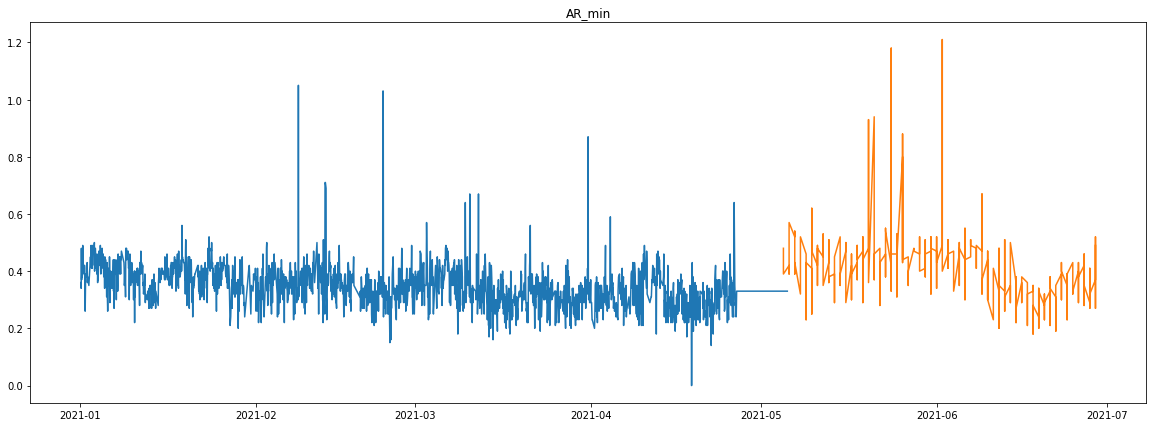

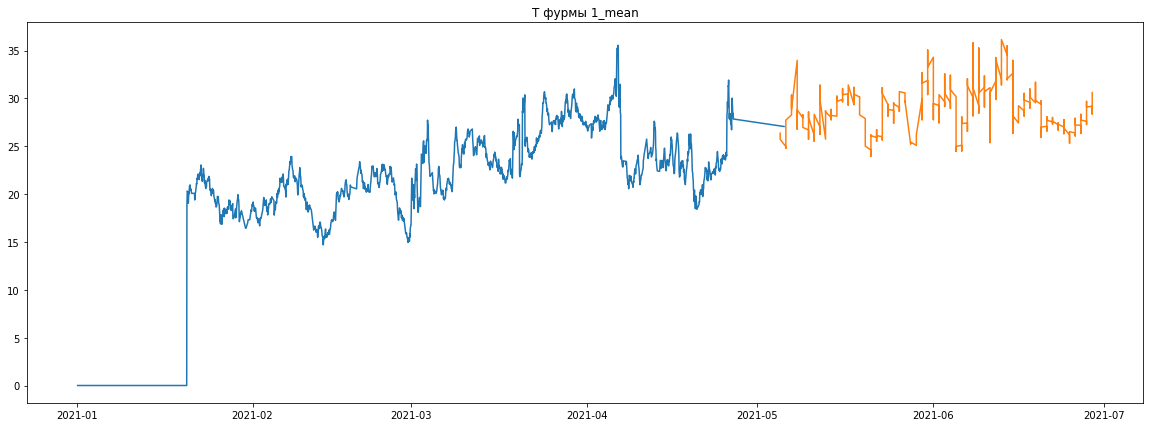

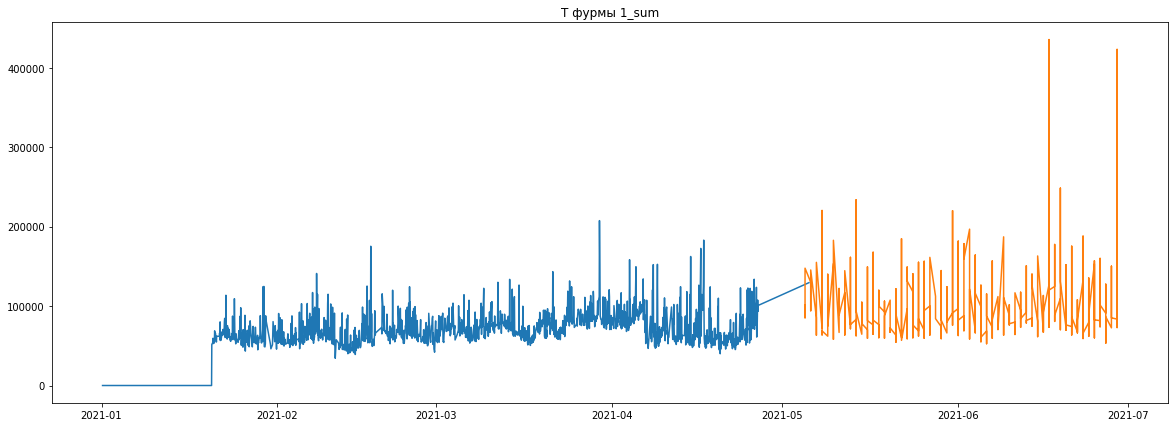

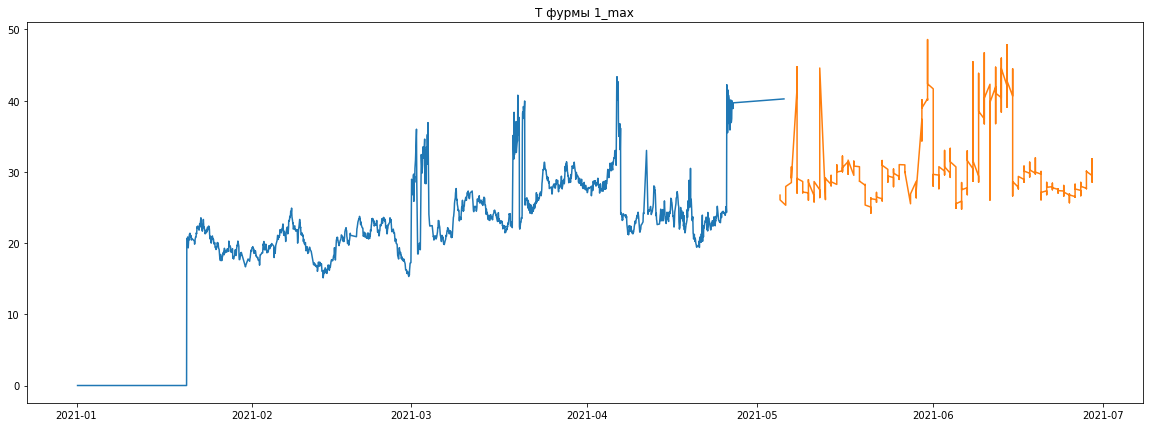

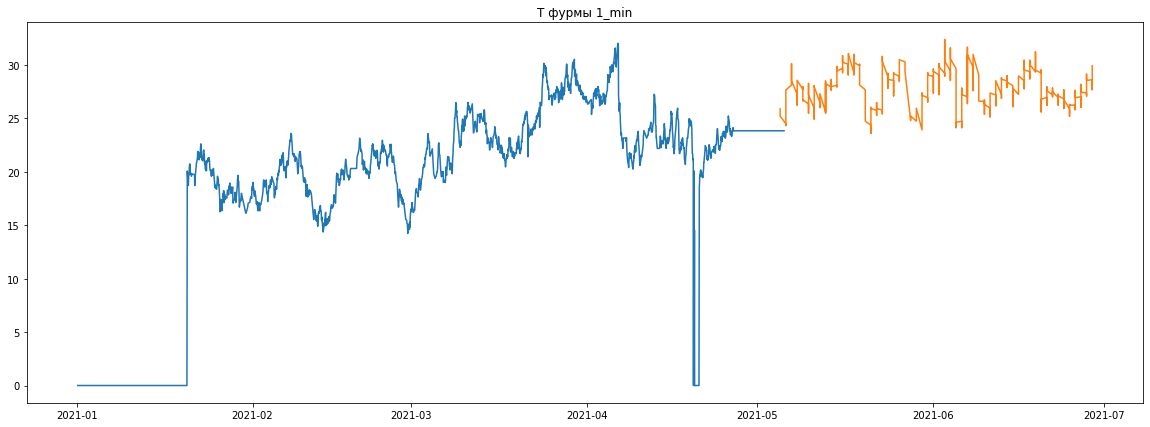

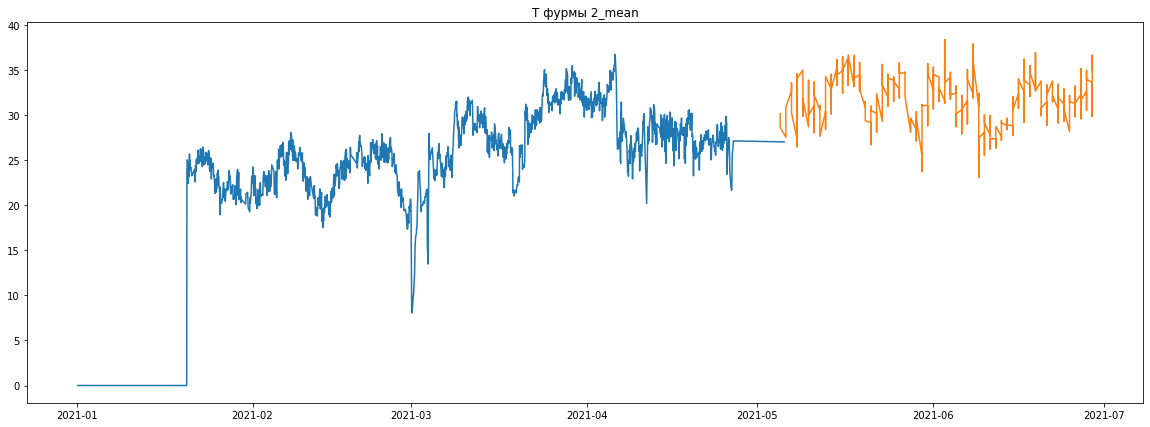

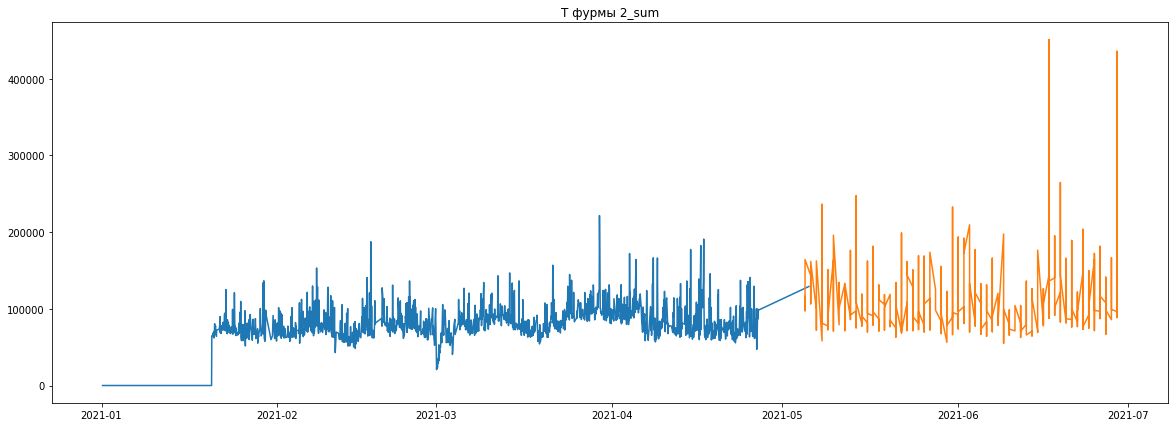

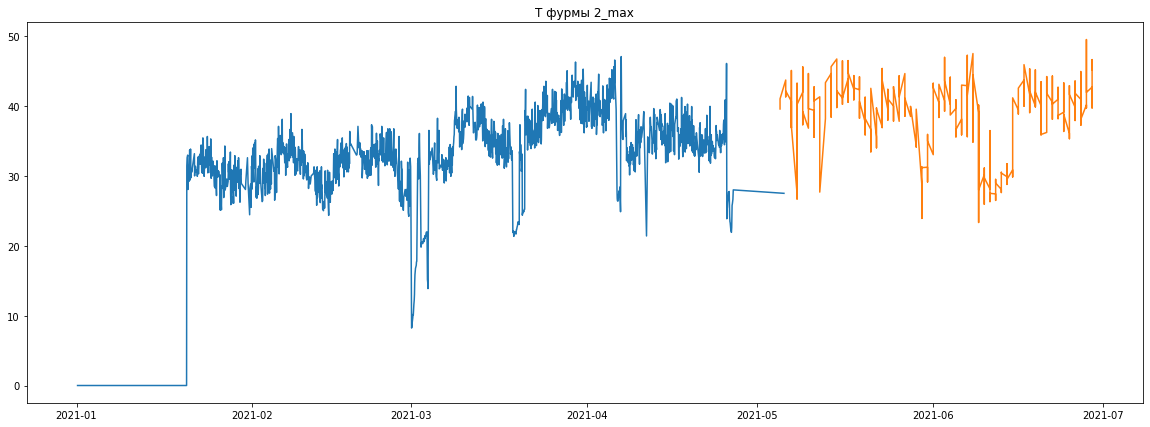

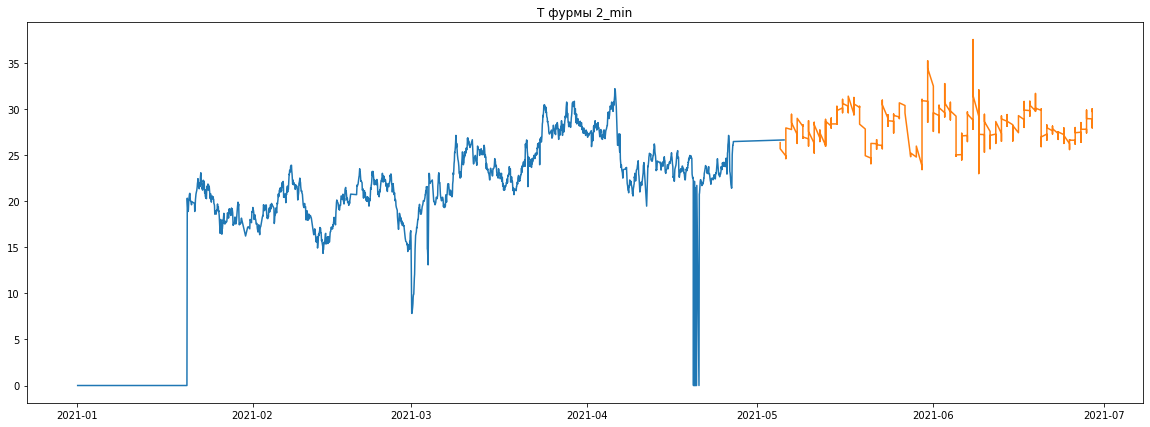

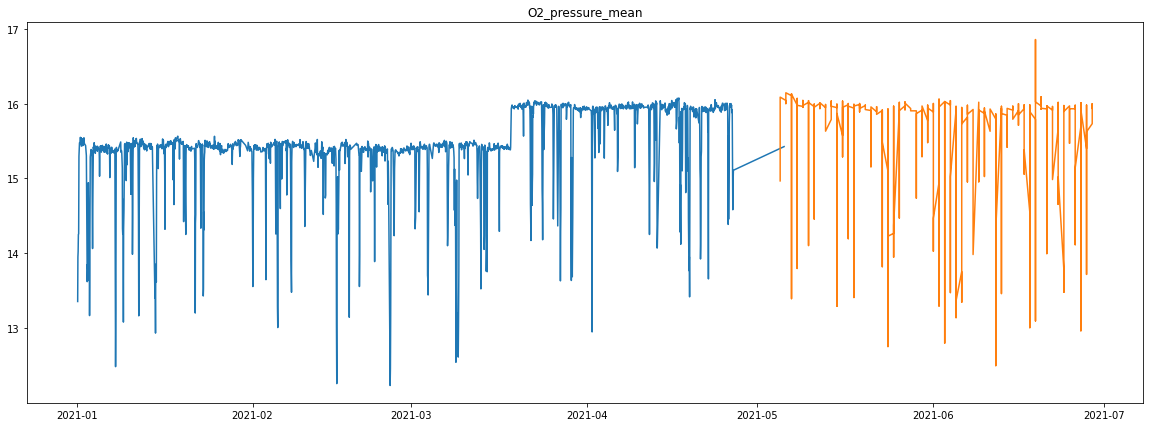

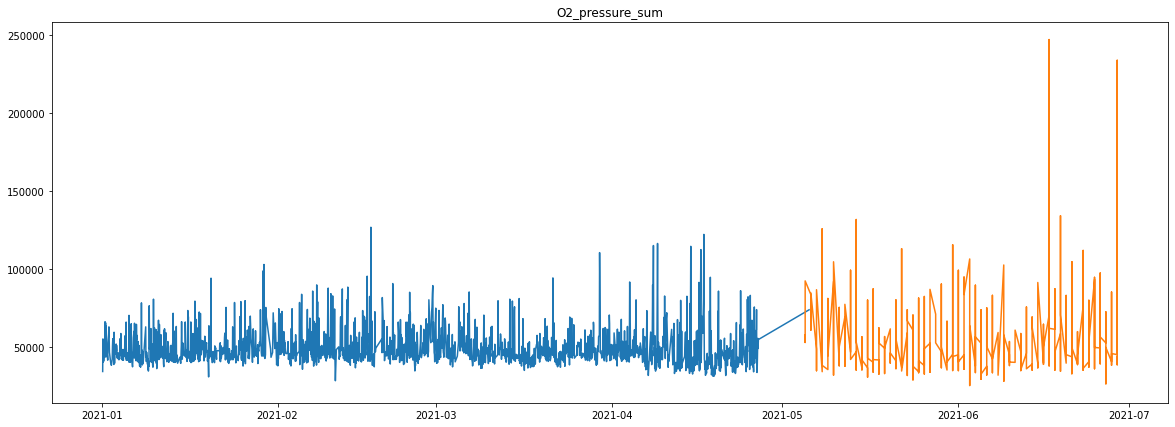

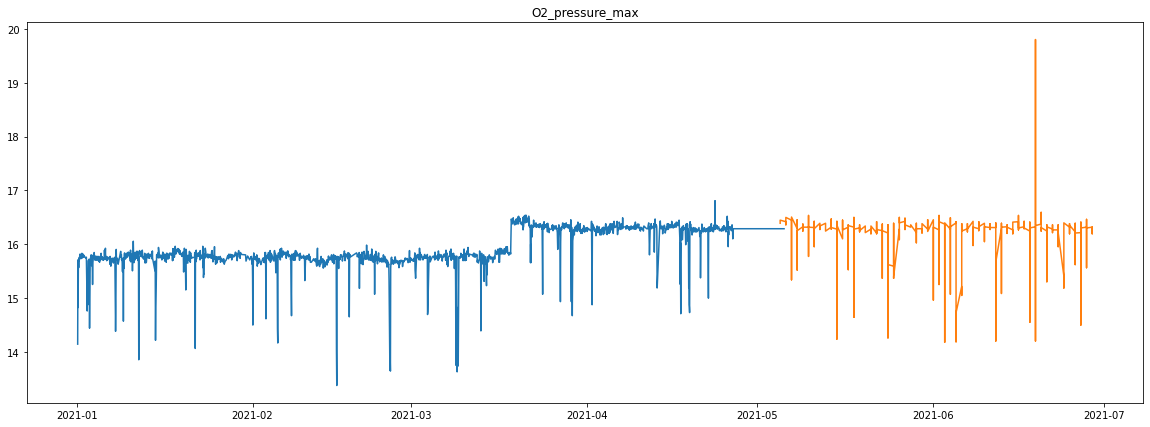

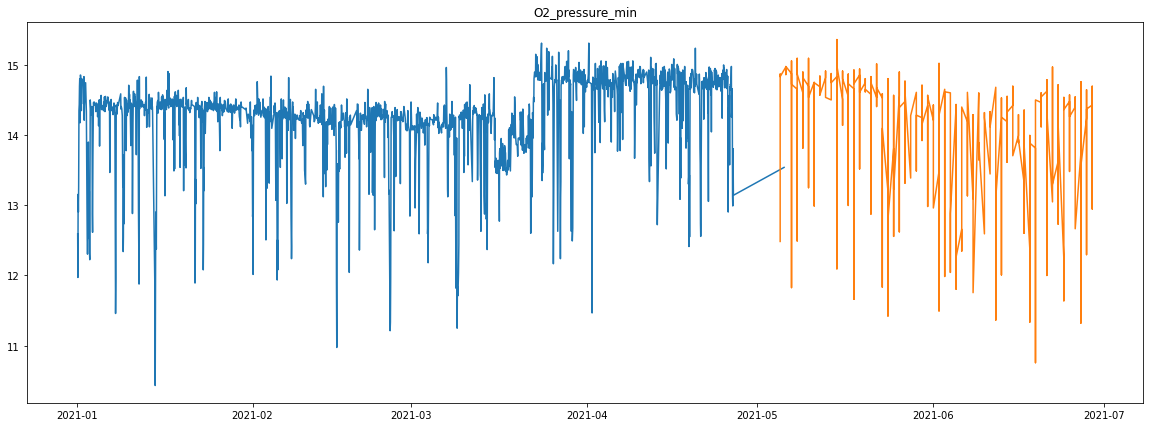

In [1983]:
for col, feature in zip(X.columns, f_columns):
    plt.figure(figsize=(20, 7))
    plt.plot(target['date'], X[col])
    plt.plot(test_dates, X_test[col])
    plt.title(feature)
    plt.show()

In [1981]:
chronom.groupby('NPLV')['VR_NACH'].last().dt.date

NPLV
512324    2021-05-05
512327    2021-05-05
512328    2021-05-05
512331    2021-05-06
512333    2021-05-06
             ...    
513369    2021-06-29
513370    2021-06-29
513371    2021-06-29
513372    2021-06-29
513374    2021-06-29
Name: VR_NACH, Length: 780, dtype: object

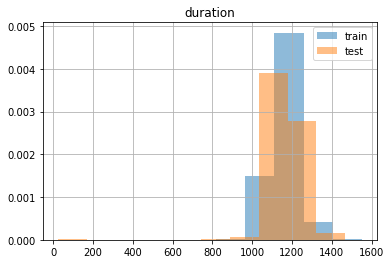

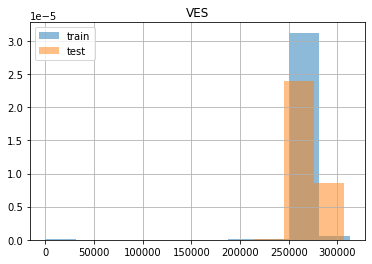

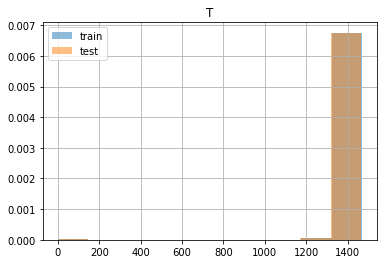

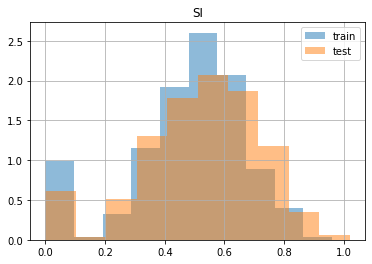

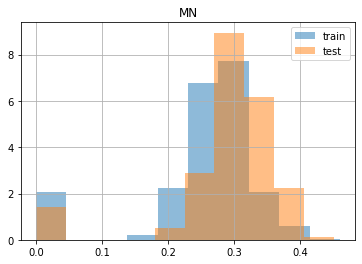

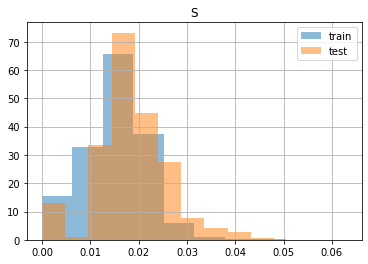

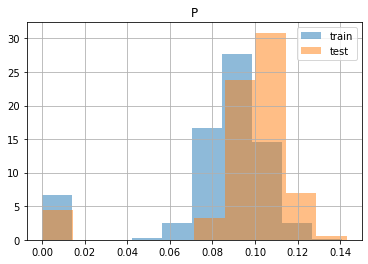

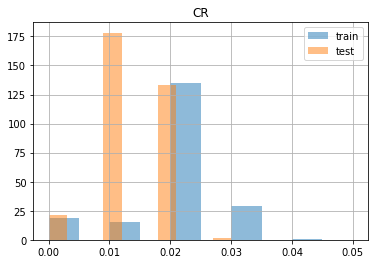

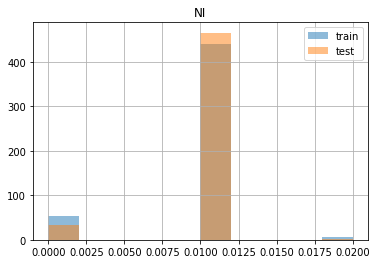

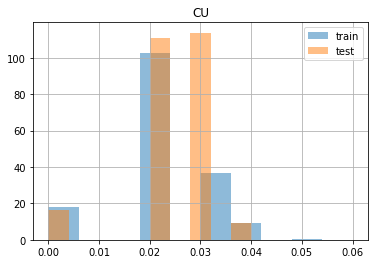

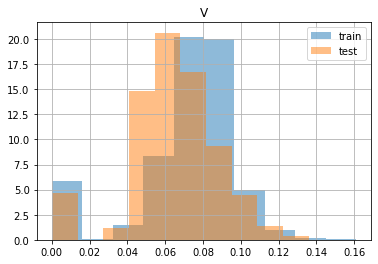

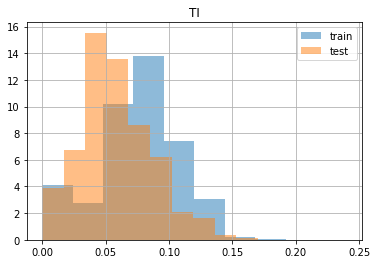

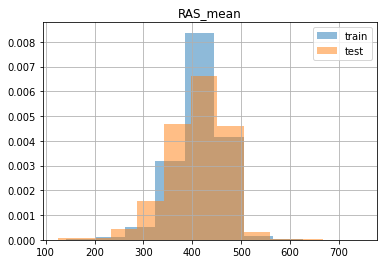

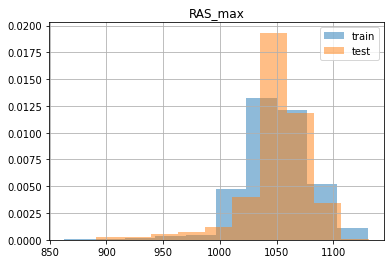

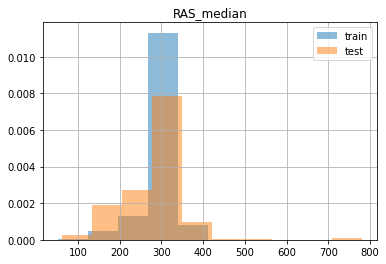

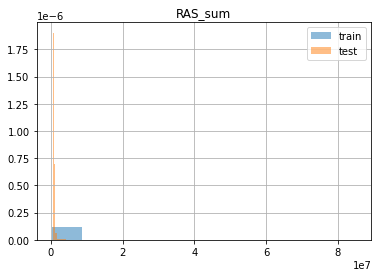

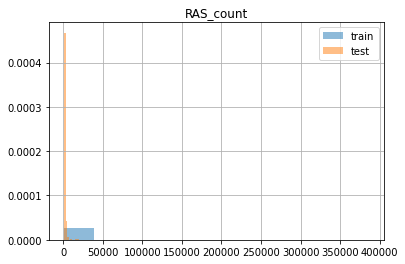

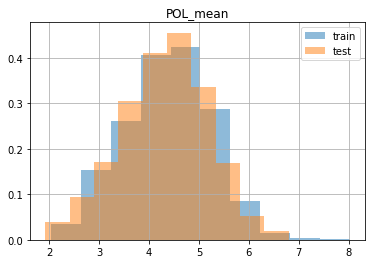

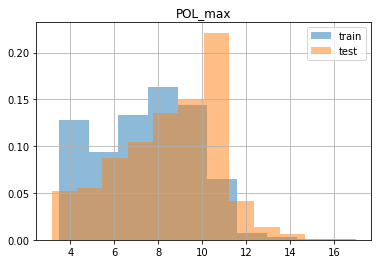

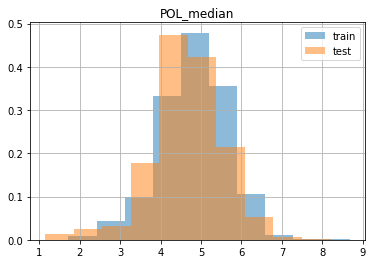

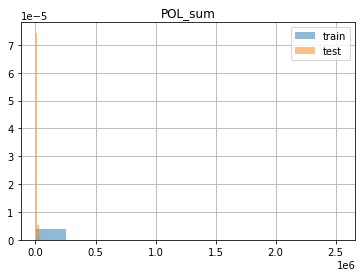

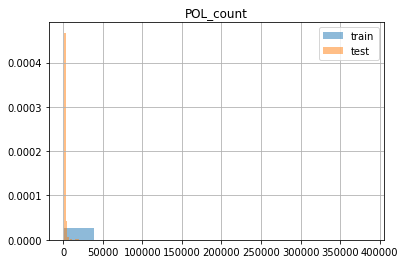

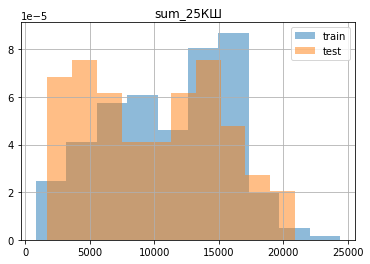

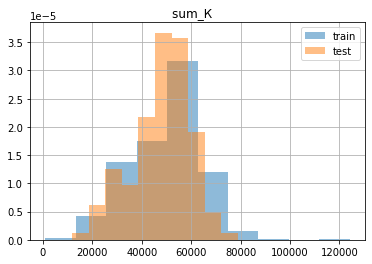

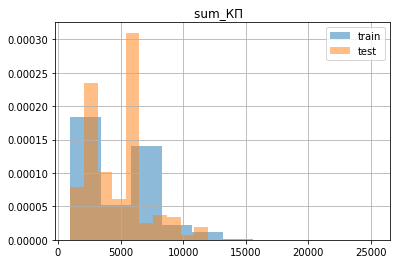

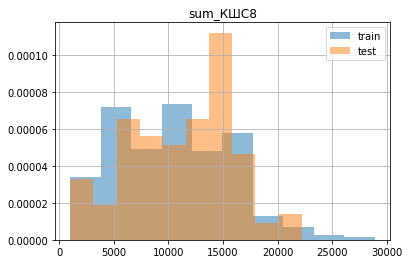

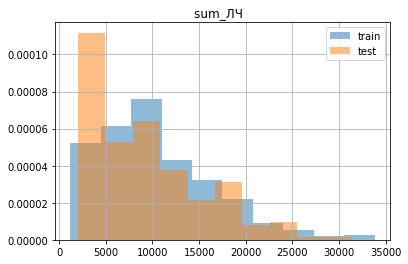

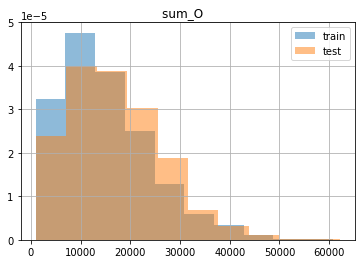

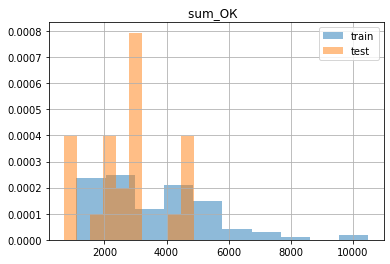

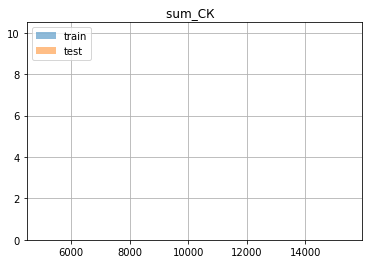

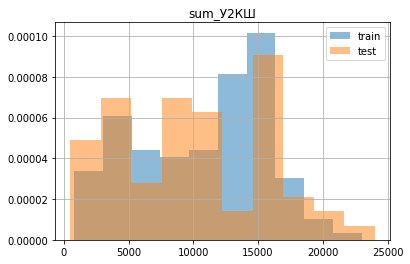

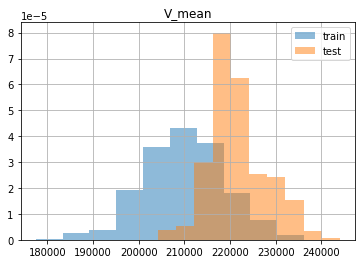

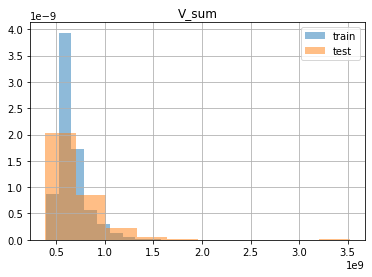

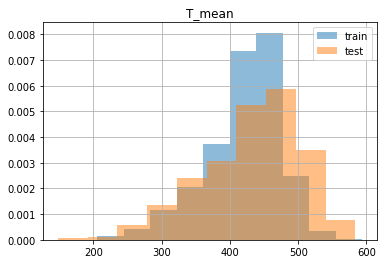

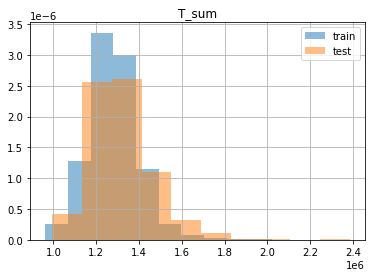

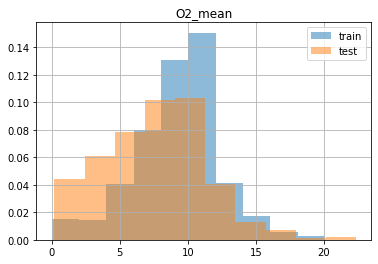

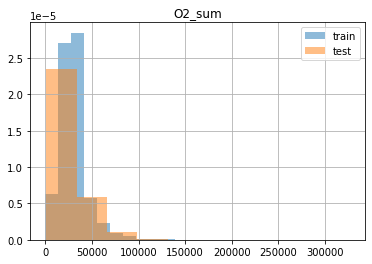

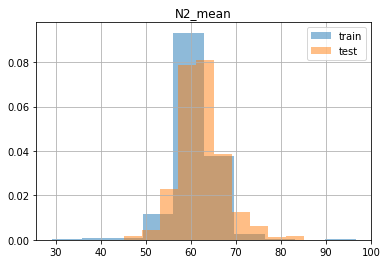

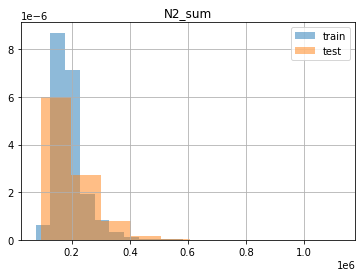

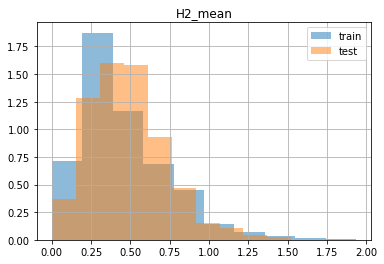

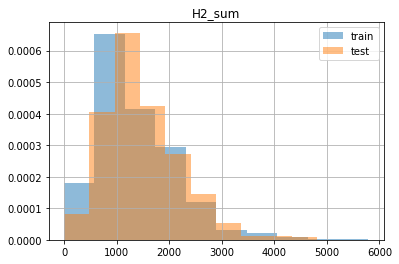

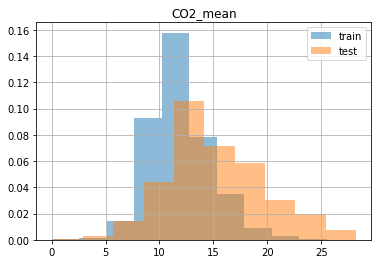

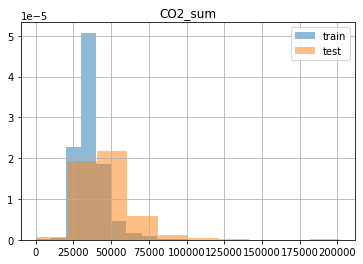

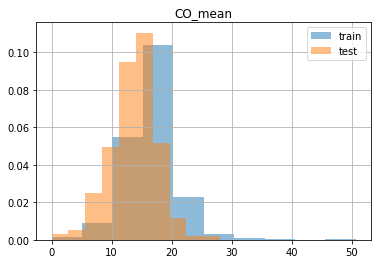

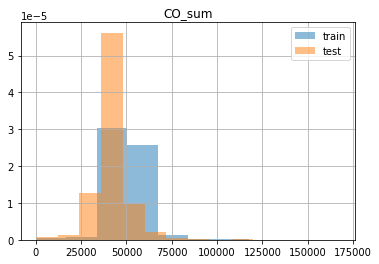

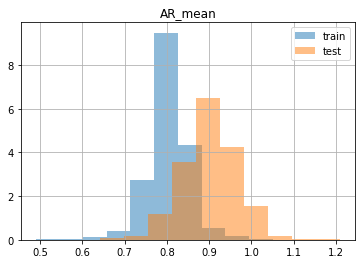

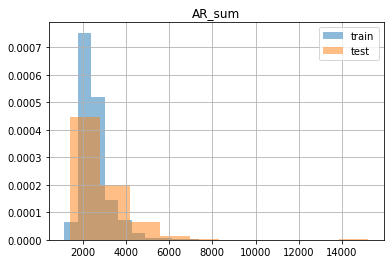

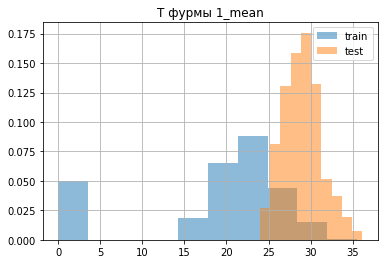

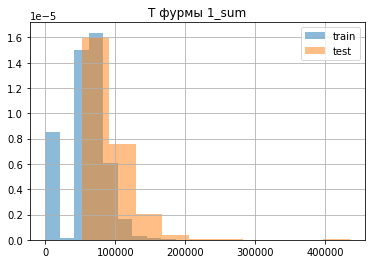

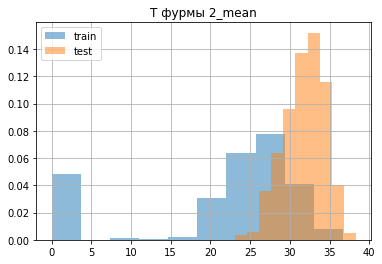

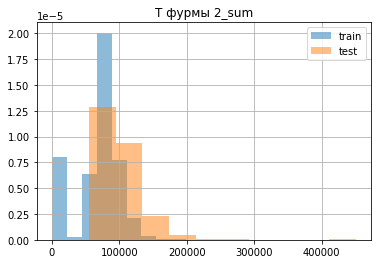

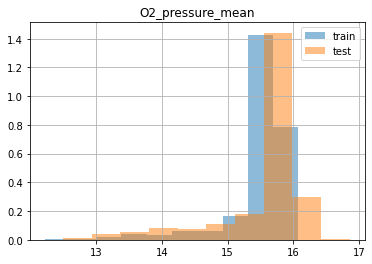

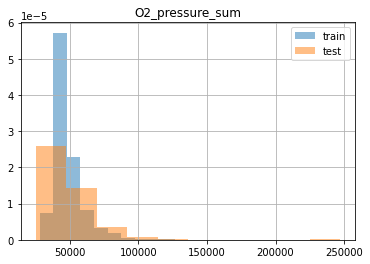

In [534]:
for i in range(X.shape[1]):
    X[f'feature_{i}'].hist(alpha=0.5, density=True)
    X_test[f'feature_{i}'].hist(alpha=0.5, density=True)
    plt.legend(['train', 'test'])
    plt.title(f_columns[i])
    plt.show()

In [1440]:
chronom[chronom['NPLV'] == chronom['NPLV'].unique()[9]]


Unnamed: 0    NPLV     TYPE_OPER                  NOP             VR_NACH  \
73          73  512350  межпл.прост.       межпл. простой 2011-05-09 00:19:47   
74          74  512350  межпл.прост.       межпл. простой 2021-05-07 07:15:09   
75          75  512350  межпл.прост.    Осмотр конвертера 2021-05-07 07:15:22   
76          76  512350  межпл.прост.  Наведение гарнисажа 2021-05-07 07:18:10   
77          77  512350  межпл.прост.   Наложение продувки 2021-05-07 07:22:17   
78          78  512350  межпл.прост.           Слив шлака 2021-05-07 07:22:25   
79          79  512350  межпл.прост.   Наложение продувки 2021-05-07 07:23:22   
80          80  512350          опер         Завалка лома 2021-05-07 07:26:25   
81          81  512350  вн.пл.прост.   Наложение продувки 2021-05-07 07:27:19   
82          82  512350          опер       Заливка чугуна 2021-05-07 07:32:19   
83          83  512350  вн.пл.прост.   Наложение продувки 2021-05-07 07:39:05   
84          84  512350          опер             Продувка 2021-05-07 07:39:37   

                VR_KON  O2  
73 2011-05-09 00:33:23 NaN  
74 2021-05-07 07:26:25 NaN  
75 2021-05-07 07:18:10 NaN  
76 2021-05-07 07:22:17 NaN  
77 2021-05-07 07:22:25 NaN  
78 2021-05-07 07:23:22 NaN  
79 2021-05-07 07:26:30 NaN  
80 2021-05-07 07:32:19 NaN  
81 2021-05-07 07:32:19 NaN  
82 2021-05-07 07:39:37 NaN  
83 2021-05-07 07:39:37 NaN  
84 2021-05-07 07:59:51 NaN

In [536]:
chronom['NOP'].value_counts()

межпл. простой          1560
Слив шлака               891
Завалка лома             780
Заливка чугуна           780
Продувка                 780
Наведение гарнисажа      733
Осмотр конвертера        692
Нагрев лома              512
Вхождение в гр.МНЛЗ      257
Наложение продувки       226
Отсутствие чугуна        177
Обрыв горловины          121
Неиспр. электр. обор      67
Отсутствие O2             57
Отсут. своб.разл.пл.      48
Подварка  футеровки       35
Ожидание шл.чаш           28
Замер положения фурм      25
Полусухое торкрет.        22
ППР                       14
Замена фурмы              10
Ожидание стальковша        6
Неиспр. механ. обор.       6
Ремонт летки               6
Неиспр. энерг. обор        5
Отсутствие мет.шихты       4
Неиспр. АСУ и КИПиА        2
Подача чугуна              1
Name: NOP, dtype: int64

In [537]:
nplv = chronom[chronom['NOP'] == 'Додувка на C']['NPLV']

In [538]:
target['with_doduv'] = target['NPLV'].isin(nplv)

In [539]:
target.groupby('with_doduv')[['TST', 'C']].agg(['count', 'median'])

TST            C       
           count median count median
with_doduv                          
False       2063   1652  2061  0.056

In [471]:
np.mean(np.abs(target['C'] - target.groupby('with_doduv')['C'].transform('median')) < 0.02)

0.626757149781871

In [472]:
np.mean(np.abs(target['C'] - target['C'].median()) < 0.02)

0.626757149781871

<AxesSubplot:>

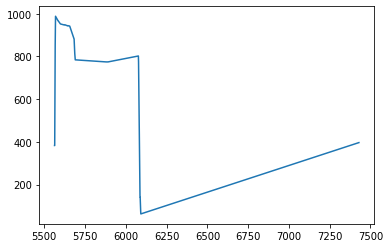

In [631]:
produv[produv['NPLV'] == produv['NPLV'].unique()[3]]['RAS'].plot()


In [549]:
produv[produv['NPLV'] == produv['NPLV'].unique()[3]]

NPLV                  SEC         RAS       POL
7707  512331  2021-05-06 03:15:44  386.000000  4.180000
7708  512331  2021-05-06 03:15:46  582.000000  4.190000
7709  512331  2021-05-06 03:15:48  750.000000  4.190000
7710  512331  2021-05-06 03:15:50  750.000000  4.190000
7711  512331  2021-05-06 03:15:52  877.000000  3.950000
...      ...                  ...         ...       ...
9714  512331  2021-05-06 04:22:38  409.728134  4.042631
9715  512331  2021-05-06 04:22:40  409.982507  4.038105
9716  512331  2021-05-06 04:22:42  410.236880  4.033579
9717  512331  2021-05-06 04:22:44  410.491254  4.029052
9718  512331  2021-05-06 04:22:46  410.745627  4.024526

[2012 rows x 4 columns]

In [ ]:
pd.concat([chronom_features, chugun_features, produv_features, lom_features, gas_features], axis=1)

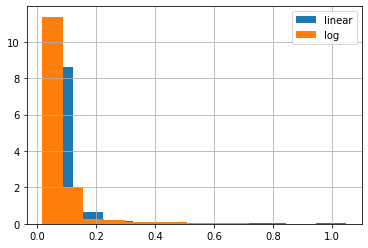

In [1998]:
target['C'].hist(density=True)
np.log(1 + target['C']).hist(density=True)
plt.legend(['linear', 'log'])

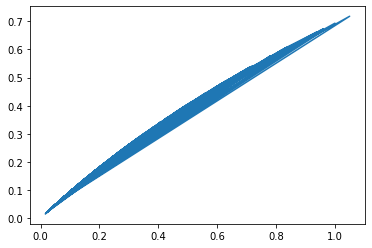

In [1999]:
plt.plot(target['C'], np.log(1 + target['C']))